<a href="https://colab.research.google.com/github/mokshmalik5757/Bitcoin_Price_Prediction_2021/blob/main/TSA_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (20, 10)

In [ ]:
# Load Bitcoin price data
df = pd.read_csv(r"C:\Users\Moksh\Dropbox\PC\Downloads\BTC-2021min.csv\BTC-2021min.csv", parse_dates = ['date'], usecols = ["date", "open", "high", "low", "close", "Volume BTC", "Volume USD"])

In [ ]:
df.set_index("date", inplace=True)

In [ ]:
small_df = df.iloc[:30000, :]

In [ ]:
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality, plot_acf, plot_pacf, plot_residuals_analysis, remove_seasonality, remove_trend, stationarity_test_adf, stationarity_test_kpss, stationarity_tests

Since, ARIMA is for univariate, we will only use "high" column of the dataset

In [ ]:
series = TimeSeries.from_dataframe(TimeSeries.from_series(small_df['high'],fill_missing_dates = True, freq = None).pd_dataframe().fillna(method='ffill'))

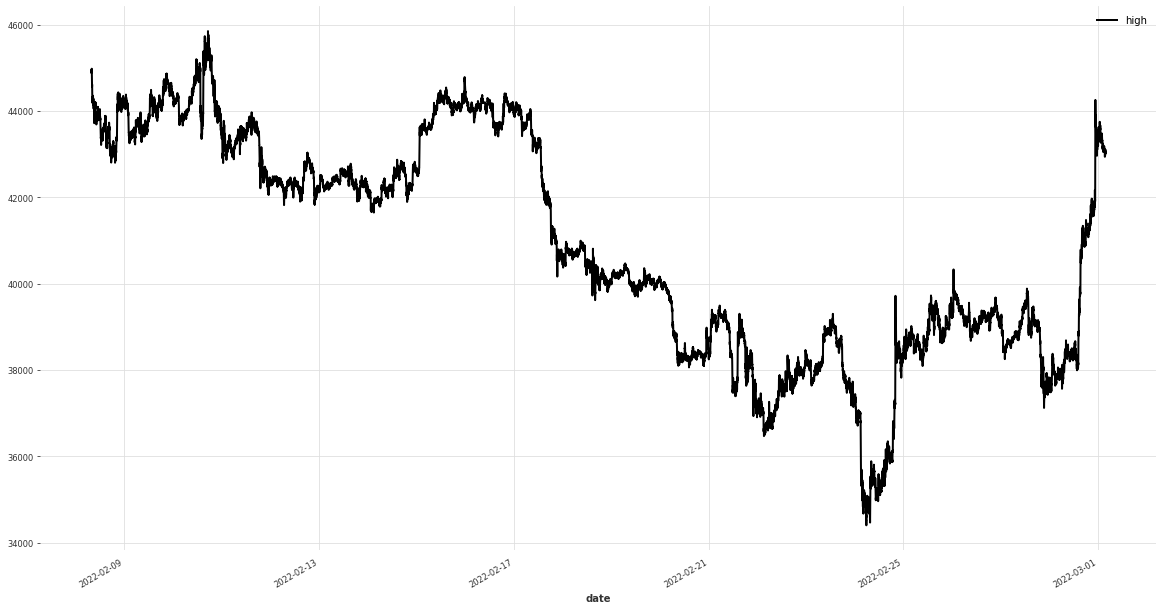

In [ ]:
series.plot()

In [ ]:
stationarity_test_adf(series, autolag="AIC")

(-1.5901969875663273,
 0.4885160143353668,
 38,
 29962,
 {'1%': -3.4305682718220227,
  '5%': -2.8616364702408696,
  '10%': -2.56682134816608},
 305220.62857015216)

p-value = 0.48851, so series is not stationary

In [ ]:
stationarity_test_kpss(series)

(21.45386555711838,
 0.01,
 100,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p-value = 0.01 which is smaller than 0.05, so series is trend-stationary

In [ ]:
stationarity_tests(series, p_value_threshold_adfuller=0.05, p_value_threshold_kpss=0.05)

False

This confirms that our time series is not stationary

In [ ]:
check_seasonality(series)

(False, 0)

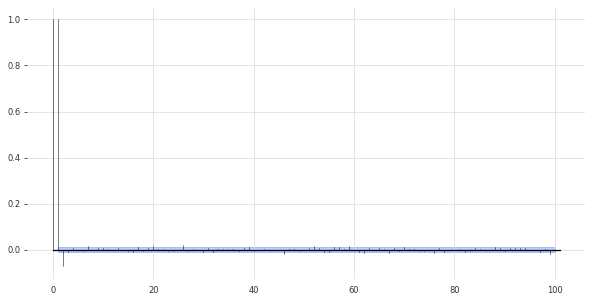

In [ ]:
plot_pacf(series, max_lag=100)

No Partial AutoCorrelation, only a single peak at lag = 1

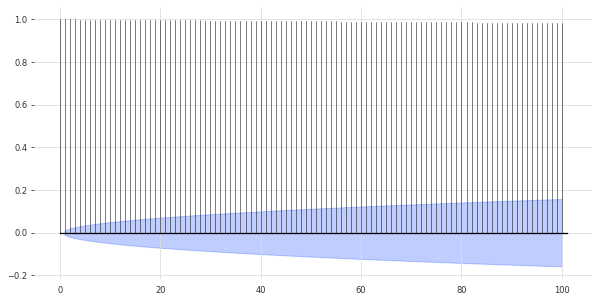

In [ ]:
plot_acf(series, max_lag=100)

ACF is high at every lag

This means, no direct influence of a single timestamp of one on another, but cumulatively, they affect the latest observation equally

In [ ]:
#train-test split

train_size = int(len(small_df) * 0.8)

series_train, series_val = series[:train_size], series[train_size:]

In [ ]:
from pmdarima.arima import AutoARIMA

In [ ]:
arima_model_pmdarima = AutoARIMA(start_p=1, d=1, start_q=2, max_p=5, max_d=5, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=False, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=-1, 
          suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto')

In [ ]:
arima_model_pmdarima.fit(series_train.pd_dataframe())

AutoARIMA(d=1, max_d=5, n_jobs=-1, seasonal=False, start_p=1)

In [ ]:
arima_model_pmdarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                24000
Model:               SARIMAX(1, 1, 4)   Log Likelihood             -121656.760
Date:                Sun, 07 May 2023   AIC                         243325.520
Time:                        19:14:41   BIC                         243374.034
Sample:                    02-08-2022   HQIC                        243341.253
                         - 02-24-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8872      0.031    -28.550      0.000      -0.948      -0.826
ma.L1          0.9450      0.031     30.173      0.000       0.884       1.006
ma.L2          0.0700      0.004     17.965      0.000       0.062       0.078
ma.L3          0.0134      0.003      4.757      0.000       0.008       0.019
ma.L4         -0.0131      0.003     -4.080      0.000      -0.019      -0.007
sigma2      1480.9535      3.427    432.132      0.000    1474.237    1487.670
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           2619328.70
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             1.89
Prob(H) (two-sided):                  0.00   Kurtosis:                        54.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
pred_arima = arima_model_pmdarima.predict(n_periods=len(series_val))

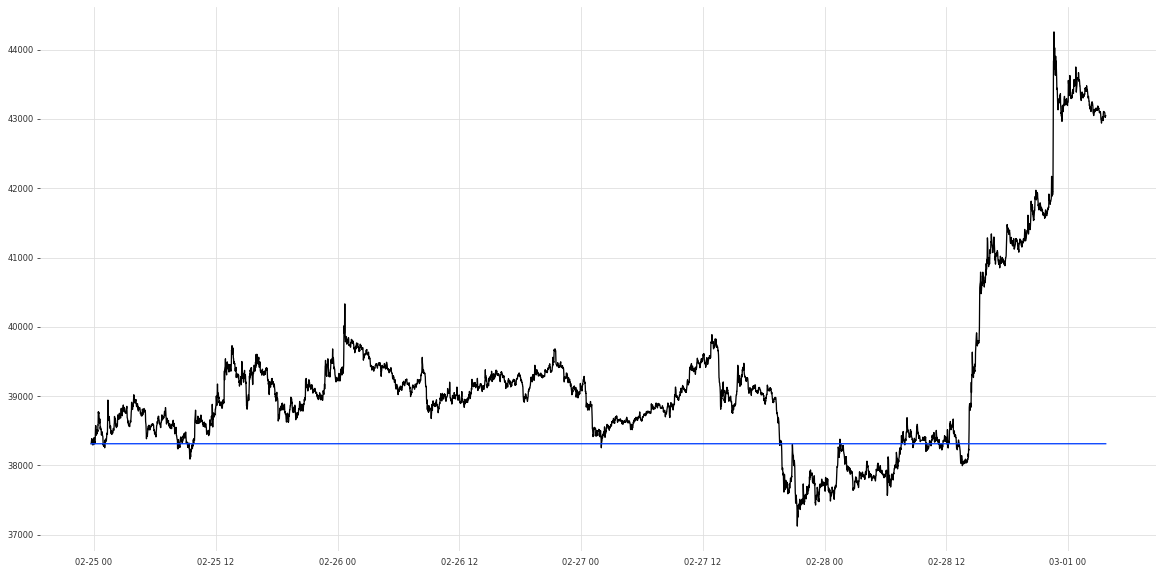

In [ ]:
plt.plot(series_val.pd_dataframe())
plt.plot(pred_arima)
plt.show()

In [ ]:
import numpy as np
from statsmodels.graphics.tsaplots import acf

def performance_metrics(forecast, actual):
    mape = np.mean((np.abs(actual - forecast)/actual)*100)
    me = np.mean(actual - forecast)
    mpe = np.mean(((forecast-actual)/actual)*100)
    mae = np.mean(np.abs(actual - forecast))
    rmse = np.sqrt(np.mean(forecast - actual)**2)
    corr = np.corrcoef(actual, forecast)[0,1]
    mins = np.amin(np.hstack([actual[:,None], forecast[:, None]]), axis = 1)
    maxs = np.amax(np.hstack([actual[:,None], forecast[:, None]]), axis = 1)
    minmax = 1 - np.mean(mins/maxs)
    acf1 = acf(actual - forecast)[1]
    return({'mape': mape, 'me': me, 'mae': mae, 'mpe':mpe, 'rmse': rmse, 'acf1': acf1, 
    'corr': corr, 'minmax': minmax})

In [ ]:
performance_metrics(series_val.pd_dataframe()['high'].values, pred_arima.values)

{'mape': 2.7089731619490545,
 'me': -914.4953701534886,
 'mae': 1037.8830816204568,
 'mpe': 2.3869195465513373,
 'rmse': 914.4953701534886,
 'acf1': 0.9985954994881794,
 'corr': 0.0013455737972132347,
 'minmax': 0.025599411005022388}

#### Let's see how ARIMA does compared to some baseline models like Naive Drift

In [ ]:
from darts.models.forecasting.baselines import NaiveDrift, NaiveSeasonal

In [ ]:
nd_model = NaiveDrift()

In [ ]:
nd_model.fit(series_train)

In [ ]:
pred_nd_model = nd_model.predict(n = len(series_val))

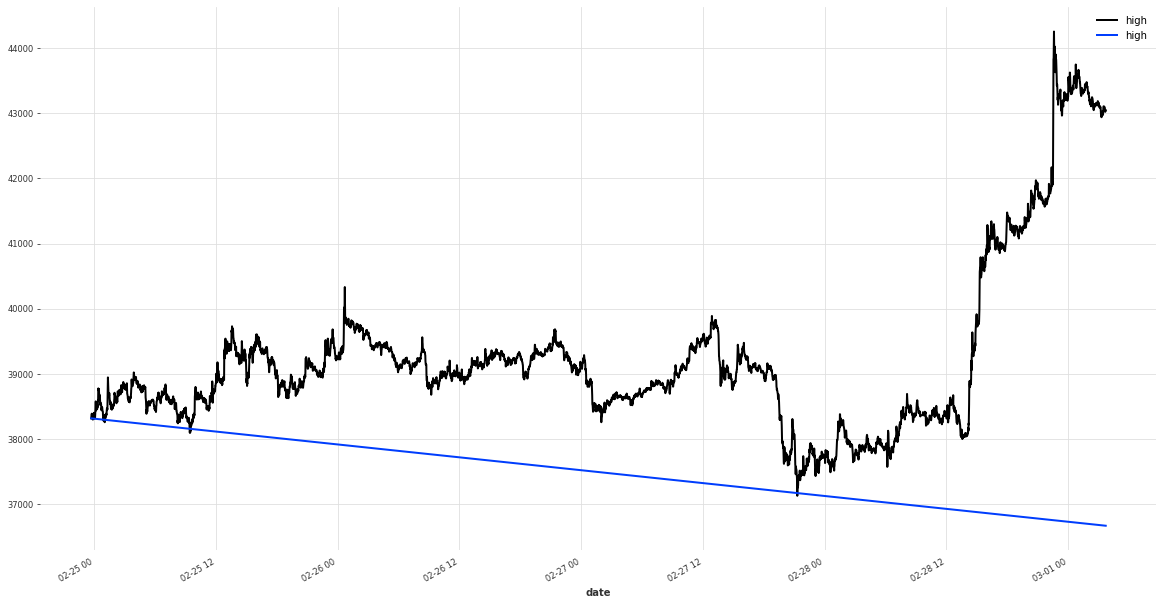

In [ ]:
series_val.plot()
pred_nd_model.plot()

In [ ]:
performance_metrics(series_val.pd_dataframe()['high'].values,pred_nd_model.pd_dataframe()['high'].values)

{'mape': 4.670454069970894,
 'me': -1738.2740887061607,
 'mae': 1738.4169282772061,
 'mpe': 4.670079189608976,
 'rmse': 1738.2740887061607,
 'acf1': 0.9986807040554364,
 'corr': -0.37846138350487424,
 'minmax': 0.04324627132149472}

In [ ]:
# Using Naive Seasonal

ns_model = NaiveSeasonal(K=1)

In [ ]:
ns_model.fit(series_train)

In [ ]:
pred_ns_model = ns_model.predict(n = len(series_val))

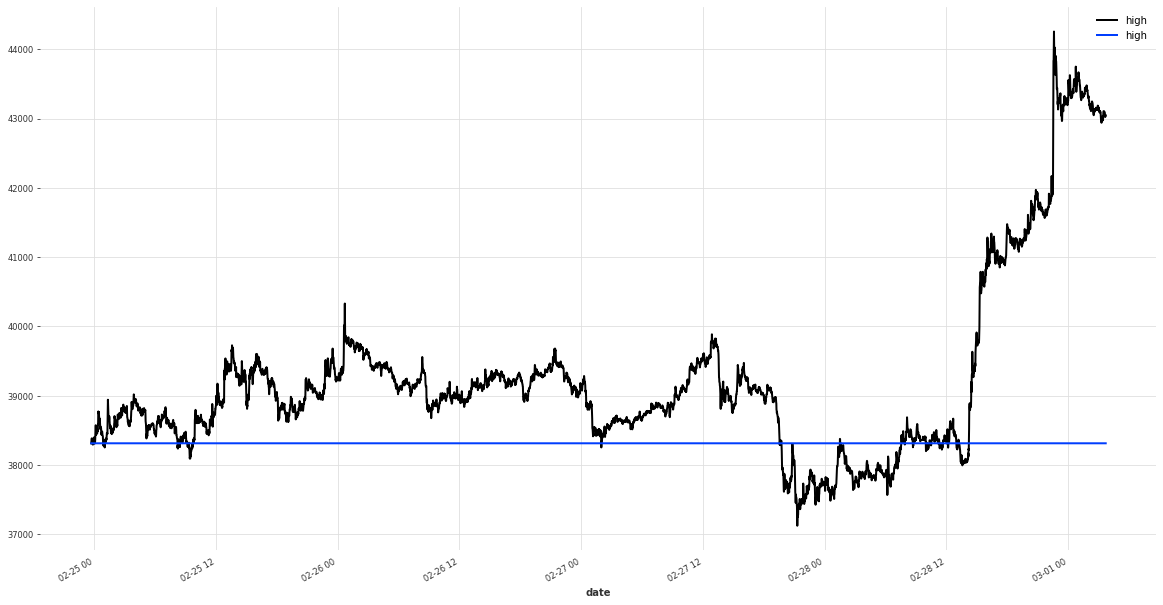

In [ ]:
series_val.plot()
pred_ns_model.plot()

In [ ]:
performance_metrics(series_val.pd_dataframe()['high'].values,pred_ns_model.pd_dataframe()['high'].values)

{'mape': 2.7064480981456445,
 'me': -913.1710281619725,
 'mae': 1036.9515014164301,
 'mpe': 2.38338050436764,
 'rmse': 913.1710281619725,
 'acf1': 0.9985954959910275,
 'corr': 4.115160550049395e-15,
 'minmax': 0.02557586925388433}

#### From this, we can see that ARIMA performed better than Baseline models.

## Exponential Smoothing

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
es_model = ExponentialSmoothing(series_train.pd_dataframe(),trend="add", seasonal=None )

In [ ]:
es_model.fit(optimized=True)

c:\anaconda\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
es_model.params

{'smoothing_level': 0.9949004999025101,
 'smoothing_trend': 9.998010046025699e-05,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 44909.73801570774,
 'initial_trend': 4.934964054387777,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [ ]:
pred_es_model = es_model.predict(params=es_model.params, start=series_val.pd_dataframe().index[0], end = series_val.pd_dataframe().index[-1])

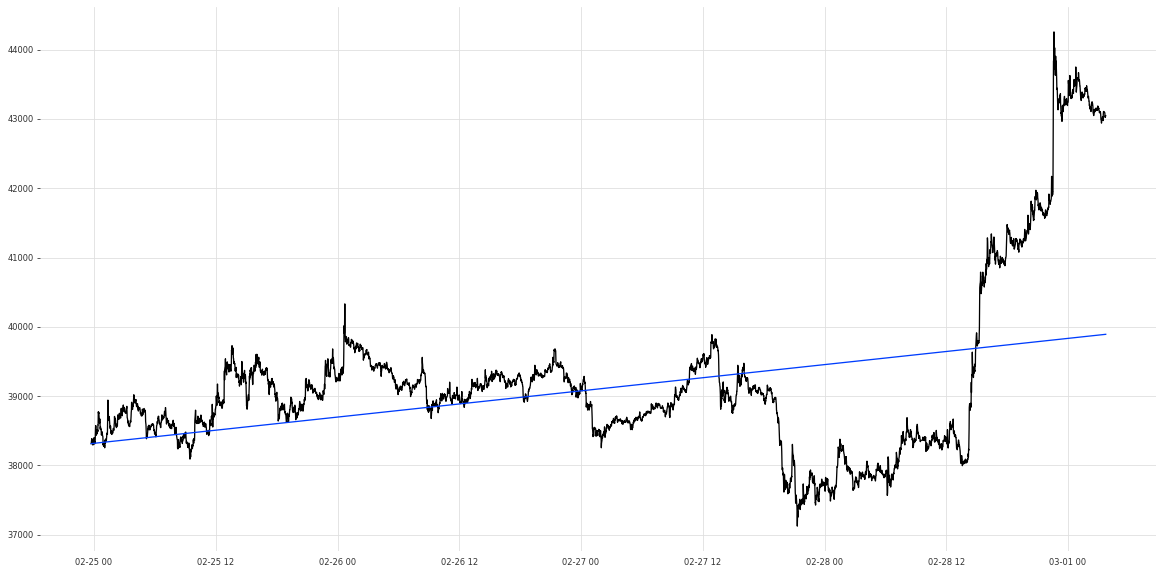

In [ ]:
plt.plot(series_val.pd_dataframe().index,series_val.pd_dataframe().values.flatten())
plt.plot(series_val.pd_dataframe().index,pred_es_model)
plt.show()

In [ ]:
performance_metrics(series_val.pd_dataframe()['high'].values, pred_es_model)

{'mape': 2.0948494209867983,
 'me': -124.07246417910767,
 'mae': 825.702275816786,
 'mpe': 0.3168330165818351,
 'rmse': 124.07246417910767,
 'acf1': 0.9987403991527943,
 'corr': 0.3784613835048743,
 'minmax': 0.020409073369498598}

In [ ]:
from statsforecast.models import AutoTheta

In [ ]:
at_model = AutoTheta(season_length=1, decomposition_type="multiplicative")

In [ ]:
at_model.fit(series_train.pd_dataframe().values.flatten())

AutoTheta

In [ ]:
pred_at_model = at_model.predict(h = len(series_val))

In [ ]:
pred_at_model

{'mean': array([38314.12109375, 38313.953125  , 38313.78515625, ...,
        37306.64453125, 37306.4765625 , 37306.30859375])}

In [ ]:
series_val.pd_dataframe()['high'].values

array([38313.44, 38335.71, 38354.02, ..., 43046.59, 43046.59, 43046.58])

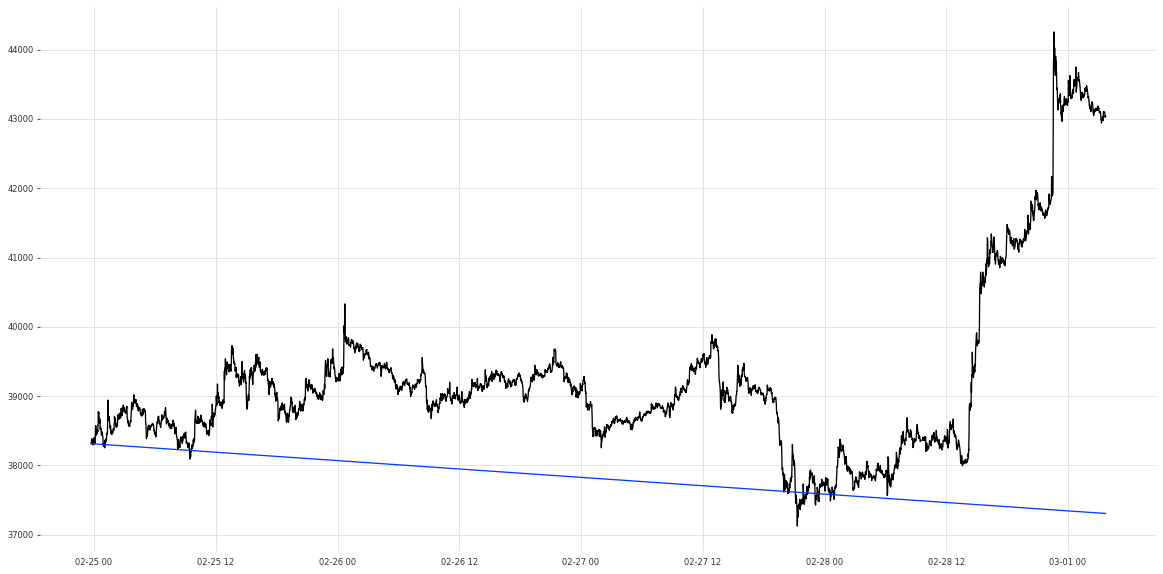

In [ ]:
plt.plot(series_val.pd_dataframe().index, series_val.pd_dataframe()['high'].values)
plt.plot(series_val.pd_dataframe().index, pred_at_model['mean'])

In [ ]:
performance_metrics(series_val.pd_dataframe()['high'].values, pred_at_model['mean'])

{'mape': 3.7748839633880196,
 'me': -1417.066184411973,
 'mae': 1421.2409497115061,
 'mpe': 3.763796720001382,
 'rmse': 1417.066184411973,
 'acf1': 0.9986311399353394,
 'corr': -0.3784613835048743,
 'minmax': 0.03520900679678596}

In [ ]:
from darts.models.forecasting.theta import FourTheta
from darts.utils.utils import ModelMode, SeasonalityMode, TrendMode


In [ ]:
ft_model = FourTheta(theta=2, model_mode = ModelMode.MULTIPLICATIVE, trend_mode=TrendMode.EXPONENTIAL)

In [ ]:
ft_model.fit(series_train)

In [ ]:
pred_ft_model = ft_model.predict(n = len(series_val))

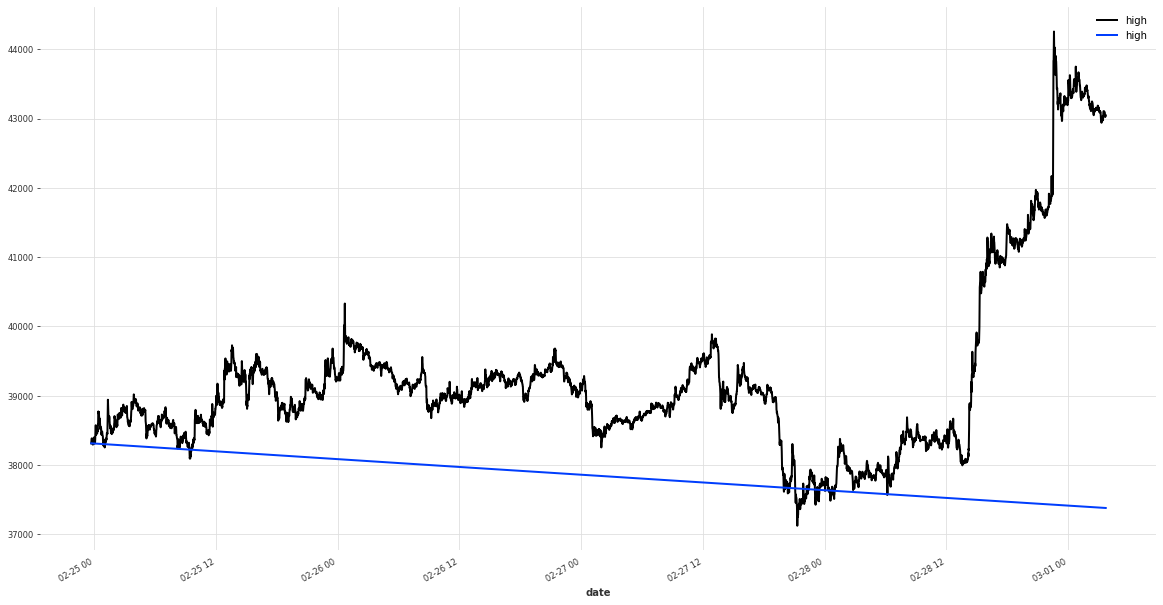

In [ ]:
series_val.plot()
pred_ft_model.plot()

In [ ]:
performance_metrics(series_val.pd_dataframe()['high'].values, pred_ft_model.pd_dataframe()['high'].values)

{'mape': 3.682429422617201,
 'me': -1381.9606869479308,
 'mae': 1388.1938520013823,
 'mpe': 3.665889817462939,
 'rmse': 1381.9606869479308,
 'acf1': 0.9986261472288188,
 'corr': -0.37705466153551526,
 'minmax': 0.03437418232646405}

### Now, taking the entire dataset, therefore making a multivariate time series dataset

In [ ]:
target = TimeSeries.from_series(small_df['high'], fill_missing_dates=True, freq = None)
cov = TimeSeries.from_dataframe(small_df.drop("high", axis=1), fill_missing_dates=True, freq = None)

In [ ]:
from darts.models.forecasting.regression_model import RegressionModel
from darts.models.forecasting.linear_regression_model import LinearRegressionModel
from darts.models.forecasting.random_forest import RandomForest
from darts.models.forecasting.catboost_model import CatBoostModel
from darts.models.forecasting.xgboost import XGBModel
from darts.models.forecasting.lgbm import LightGBMModel

In [ ]:
# data preprocessing

scaler = Scaler()

target_scaled = scaler.fit_transform(target)

cov_scaled = scaler.fit_transform(cov)

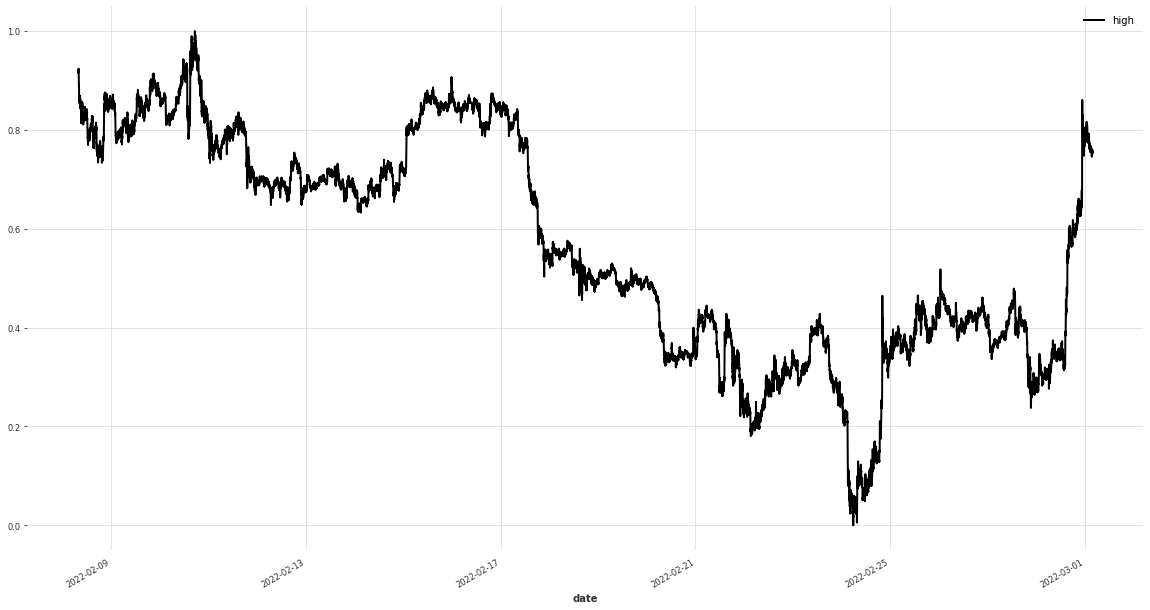

In [ ]:
target_scaled.plot()

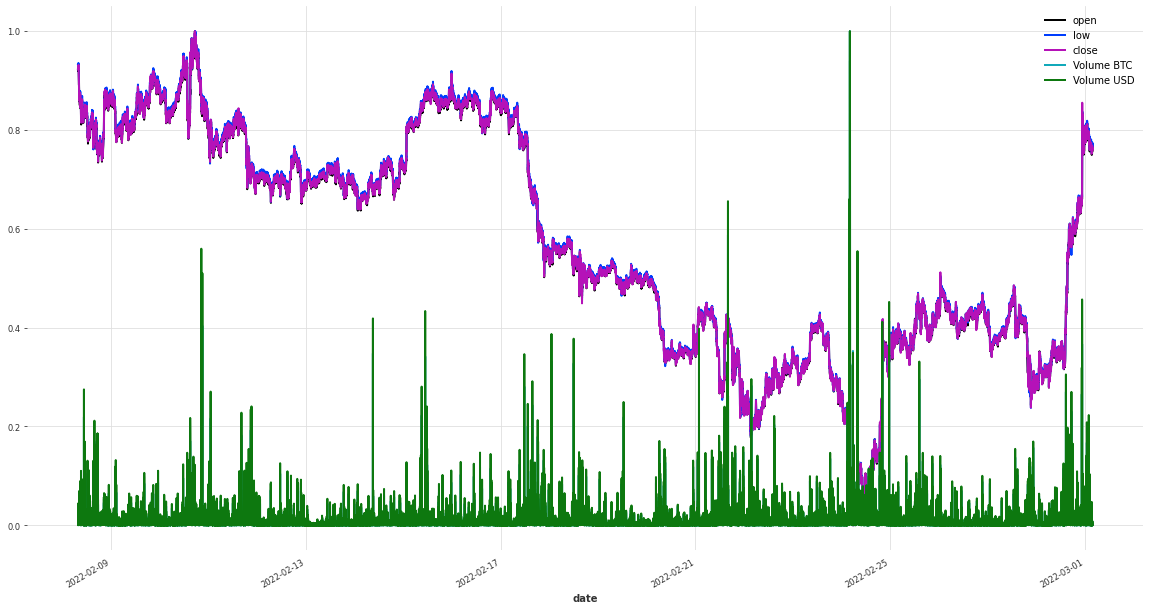

In [ ]:
cov_scaled.plot()

In [ ]:
#train-val split

train_size = int(len(small_df) * 0.8)

target_train, target_val = target_scaled[:train_size], target_scaled[train_size:]
cov_train, cov_val = cov_scaled[:train_size], cov_scaled[train_size:]

In [ ]:
lr_model = LinearRegressionModel(lags = [-1,-100], lags_past_covariates= [-1,-100], lags_future_covariates=None, output_chunk_length=3, likelihood="quantile")

In [ ]:
lr_model.fit(target_train, past_covariates=cov_train, n_jobs_multioutput_wrapper=-1)

In [ ]:
pred_lr_model = lr_model.predict(n = len(target_val), series=target_train , past_covariates=TimeSeries.from_dataframe(cov_scaled.pd_dataframe().fillna(method = "ffill")))

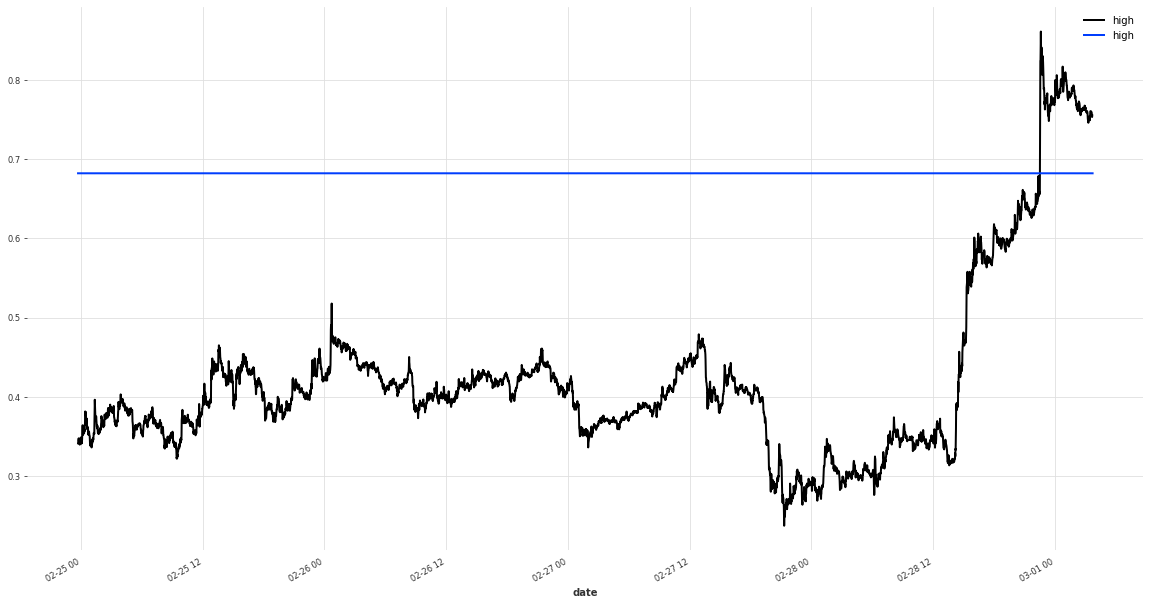

In [ ]:
target_val.plot()
pred_lr_model.plot()

In [ ]:
performance_metrics(target_val.pd_dataframe()['high'].fillna(method="ffill").values, pred_lr_model.pd_dataframe()['high'].values)

{'mape': 39.68646470862929,
 'me': 0.260687589934938,
 'mae': 0.2706513142455278,
 'mpe': -38.22545198136424,
 'rmse': 0.260687589934938,
 'acf1': 0.9985954075205322,
 'corr': -0.0012627260367373799,
 'minmax': 0.3959374090068588}

### Random Forest

In [ ]:
rf_model = RandomForest(lags = [-1,-1000], lags_past_covariates= [-1,-1000], lags_future_covariates=None, output_chunk_length=24, n_estimators=100, max_depth=None)

In [ ]:
rf_model.fit(target_train, past_covariates=cov_train, n_jobs_multioutput_wrapper=-1)

Provided `n_jobs_multioutput_wrapper` wasn't used.


In [ ]:
pred_rf_model = rf_model.predict(n = len(target_val), series=target_train , past_covariates=TimeSeries.from_dataframe(cov_scaled.pd_dataframe().fillna(method = "ffill")))

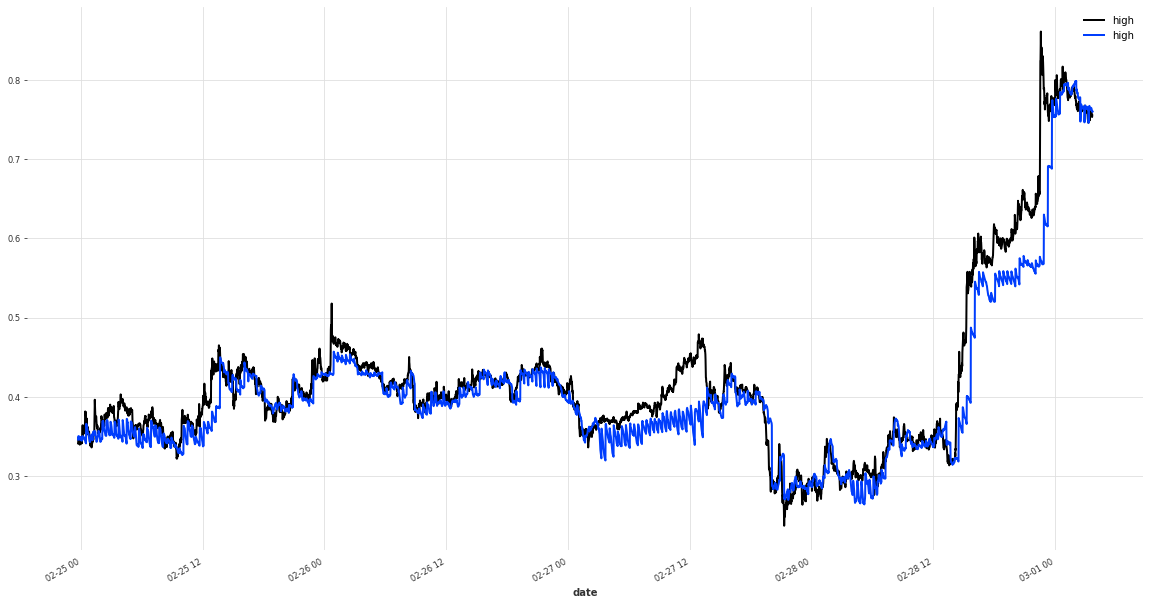

In [ ]:
target_val.plot()
pred_rf_model.plot()

In [ ]:
performance_metrics(target_val.pd_dataframe()['high'].fillna(method="ffill").values, pred_rf_model.pd_dataframe()['high'].values)

{'mape': 5.376680403804072,
 'me': -0.017101642379972522,
 'mae': 0.02183164973264981,
 'mpe': 4.115956348725731,
 'rmse': 0.017101642379972522,
 'acf1': 0.9816988425981915,
 'corr': 0.9598373931274141,
 'minmax': 0.04838811743244664}

### Cat Boost Model

In [ ]:
cb_model = CatBoostModel(lags = [-1,-1000], lags_past_covariates= [-1,-1000], lags_future_covariates=None, output_chunk_length=24, 
likelihood="gaussian" )

In [ ]:
cb_model.fit(target_train, past_covariates=cov_train, val_series= target_val, val_past_covariates=cov_val,  n_jobs_multioutput_wrapper=-1)

In [ ]:
pred_cb_model = cb_model.predict(n = len(target_val), series=target_train , past_covariates=TimeSeries.from_dataframe(cov_scaled.pd_dataframe().fillna(method = "ffill")))

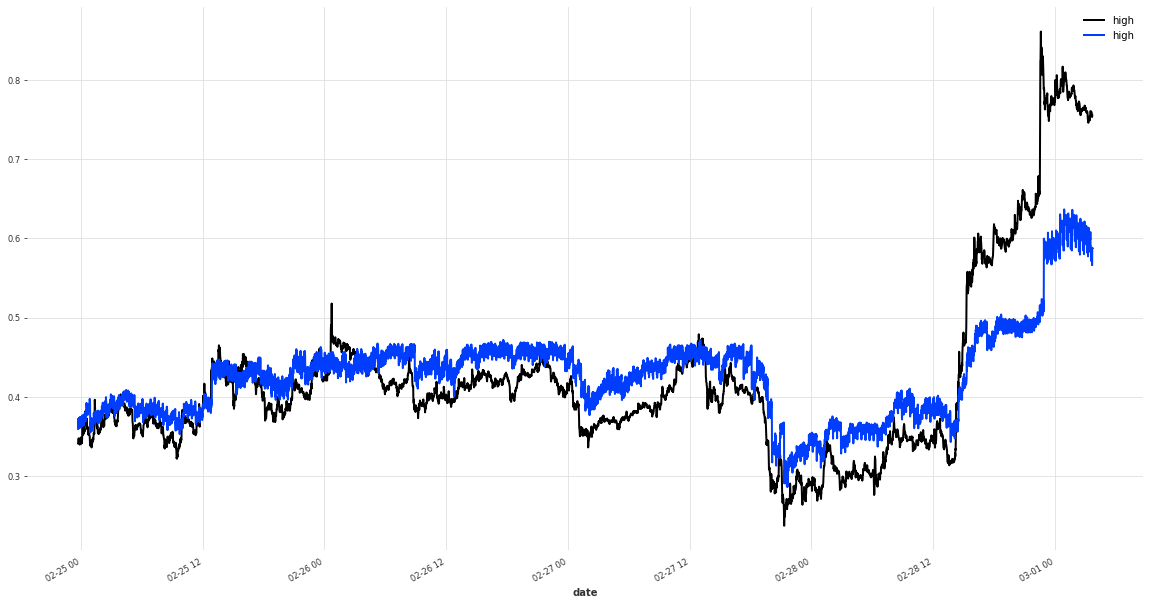

In [ ]:
target_val.plot()
pred_cb_model.plot()

In [ ]:
performance_metrics(target_val.pd_dataframe()['high'].fillna(method="ffill").values, pred_cb_model.pd_dataframe()['high'].values)

{'mape': 10.295124535921316,
 'me': 0.0064043595140799055,
 'mae': 0.04615367850732369,
 'mpe': -2.6689409845682452,
 'rmse': 0.0064043595140799055,
 'acf1': 0.9879869518834503,
 'corr': 0.9097751503640794,
 'minmax': 0.09502504295183989}

### XGBoost Model

In [ ]:
xgb_model = XGBModel(lags = [-1,-1000], lags_past_covariates= [-1,-1000], lags_future_covariates=None, output_chunk_length=24, 
likelihood="poisson" )

In [ ]:
xgb_model.fit(target_train, past_covariates=cov_train, val_series= target_val, val_past_covariates=cov_val,  n_jobs_multioutput_wrapper=-1)

In [ ]:
pred_xgb_model = xgb_model.predict(n = len(target_val), series=target_train , past_covariates=TimeSeries.from_dataframe(cov_scaled.pd_dataframe().fillna(method = "ffill")))

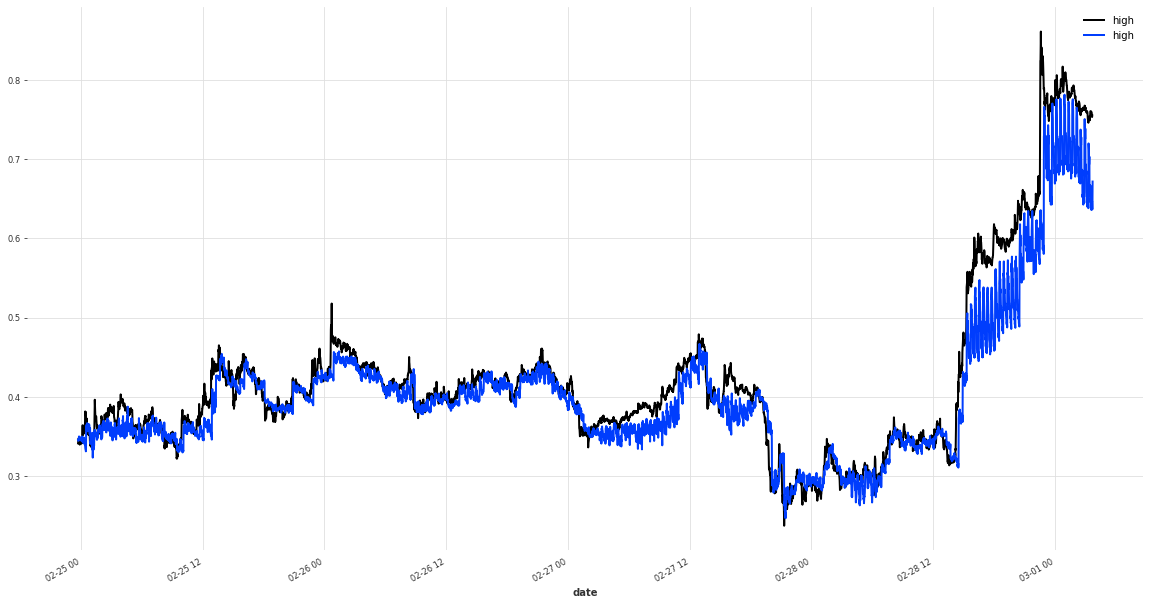

In [ ]:
target_val.plot()
pred_xgb_model.plot()

In [ ]:
performance_metrics(target_val.pd_dataframe()['high'].fillna(method="ffill").values, pred_xgb_model.pd_dataframe()['high'].values)

{'mape': 5.073684113867541,
 'me': -0.01783862382734808,
 'mae': 0.022106914337929707,
 'mpe': 3.8770249403956942,
 'rmse': 0.01783862382734808,
 'acf1': 0.9567323097754482,
 'corr': 0.9701863658780797,
 'minmax': 0.04613914576767797}

### LightGBM Model

In [ ]:
lgbm_model = LightGBMModel(lags = [-1,-1000], lags_past_covariates= [-1,-1000], lags_future_covariates=None, output_chunk_length=24, 
likelihood="poisson", random_state=42 )

In [ ]:
lgbm_model.fit(target_train, past_covariates=cov_train, val_series= target_val, val_past_covariates=cov_val,  n_jobs_multioutput_wrapper=-1)

In [ ]:
pred_lgbm_model = lgbm_model.predict(n = len(target_val), series=target_train , past_covariates=TimeSeries.from_dataframe(cov_scaled.pd_dataframe().fillna(method = "ffill")))

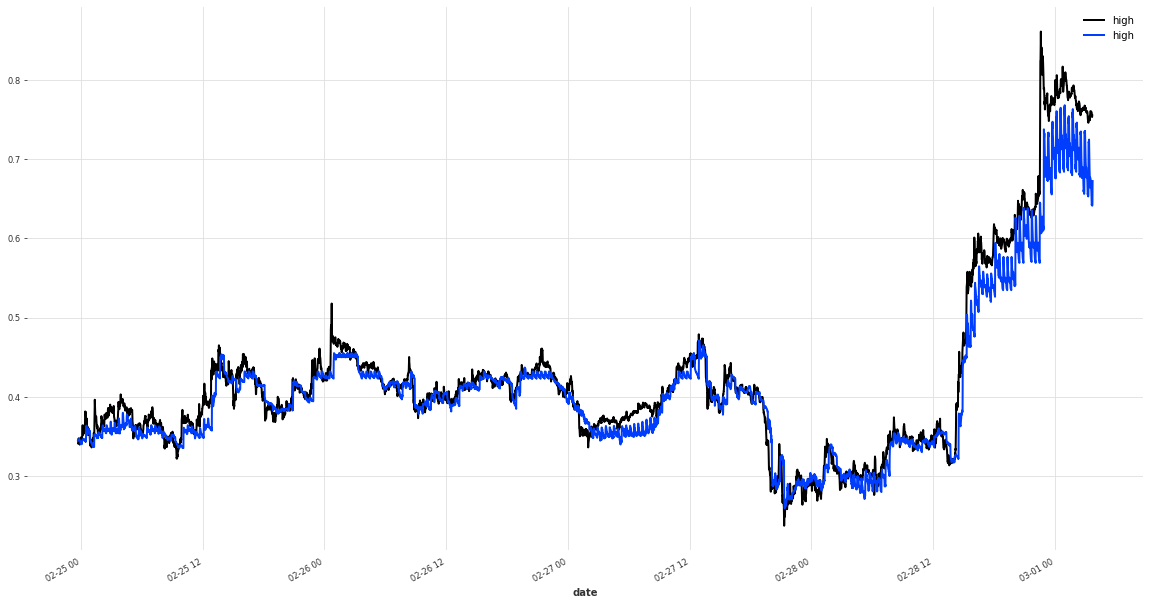

In [ ]:
target_val.plot()
pred_lgbm_model.plot()

In [ ]:
performance_metrics(target_val.pd_dataframe()['high'].fillna(method="ffill").values, pred_lgbm_model.pd_dataframe()['high'].values)

{'mape': 4.054501681289449,
 'me': -0.012973501182098888,
 'mae': 0.017920003159195213,
 'mpe': 2.6968256783456375,
 'rmse': 0.012973501182098888,
 'acf1': 0.9652105915733412,
 'corr': 0.9810294195124097,
 'minmax': 0.03781282898141103}

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 58.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 19.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)


In [ ]:
# Load Bitcoin price data
bitcoin_df = pd.read_csv(r"/content/gdrive/MyDrive/BTC-2021min.csv", parse_dates = ['date'], usecols = ["date", "open", "high", "low", "close", "Volume BTC", "Volume USD"])

In [ ]:
small_df = bitcoin_df.iloc[:30000, :]

In [ ]:
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score

In [ ]:
small_df

,date,open,high,low,close,Volume BTC,Volume USD
0,2022-03-01 03:43:00,43046.58,43046.58,43046.58,43046.58,0.000000,0.000000
1,2022-03-01 03:41:00,43018.23,43046.59,43018.23,43046.58,0.142977,6154.673021
2,2022-03-01 03:40:00,43022.24,43022.24,43016.03,43016.03,0.009230,397.037957
3,2022-03-01 03:39:00,43035.16,43035.16,42999.44,42999.44,0.820950,35300.390268
4,2022-03-01 03:38:00,43077.82,43077.82,43049.46,43049.46,0.022210,956.143143
...,...,...,...,...,...,...,...
29995,2022-02-08 07:47:00,44861.69,44884.22,44861.69,44884.22,0.031300,1404.876086
29996,2022-02-08 07:46:00,44890.16,44890.16,44844.50,44861.69,0.910237,40834.790757
29997,2022-02-08 07:45:00,44917.76,44917.76,44885.10,44890.16,7.895788,354443.169588
29998,2022-02-08 07:44:00,44911.20,44912.32,44906.50,44912.32,0.365327,16407.675943


In [ ]:
small_df.set_index("date", inplace = True)

In [ ]:
small_df.drop('high', axis = 1)

,open,low,close,Volume BTC,Volume USD
date,,,,,
2022-03-01 03:43:00,43046.58,43046.58,43046.58,0.000000,0.000000
2022-03-01 03:41:00,43018.23,43018.23,43046.58,0.142977,6154.673021
2022-03-01 03:40:00,43022.24,43016.03,43016.03,0.009230,397.037957
2022-03-01 03:39:00,43035.16,42999.44,42999.44,0.820950,35300.390268
2022-03-01 03:38:00,43077.82,43049.46,43049.46,0.022210,956.143143
...,...,...,...,...,...
2022-02-08 07:47:00,44861.69,44861.69,44884.22,0.031300,1404.876086
2022-02-08 07:46:00,44890.16,44844.50,44861.69,0.910237,40834.790757
2022-02-08 07:45:00,44917.76,44885.10,44890.16,7.895788,354443.169588


In [ ]:
target = TimeSeries.from_series(small_df['high'],fill_missing_dates = True, freq = None)

In [ ]:
past_cov = TimeSeries.from_dataframe(small_df.drop('high', axis = 1),fill_missing_dates = True, freq = None)

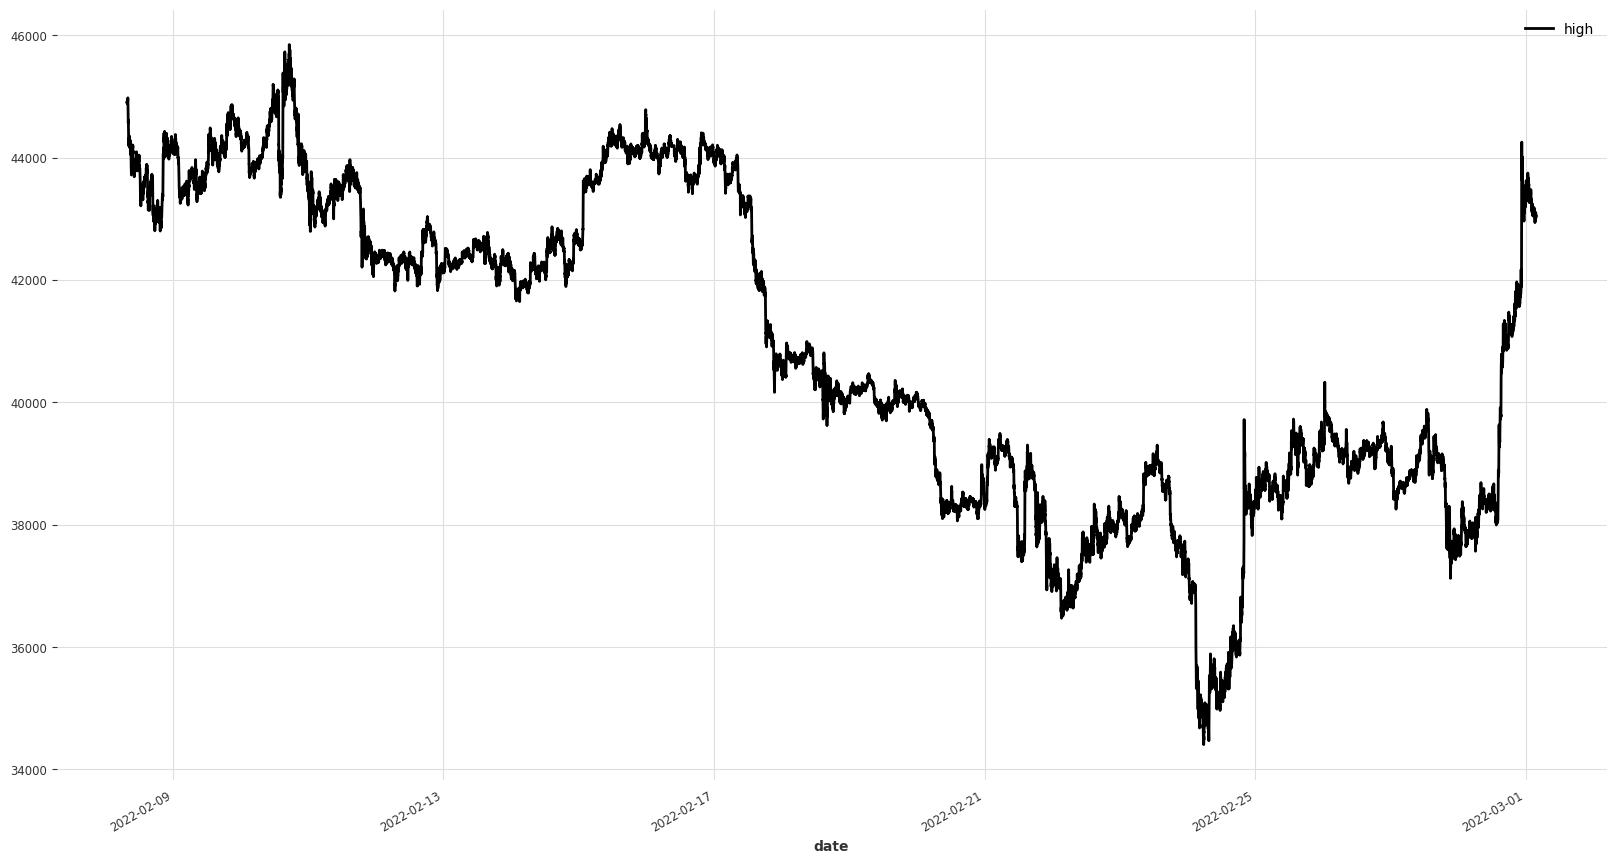

In [ ]:
target.plot()

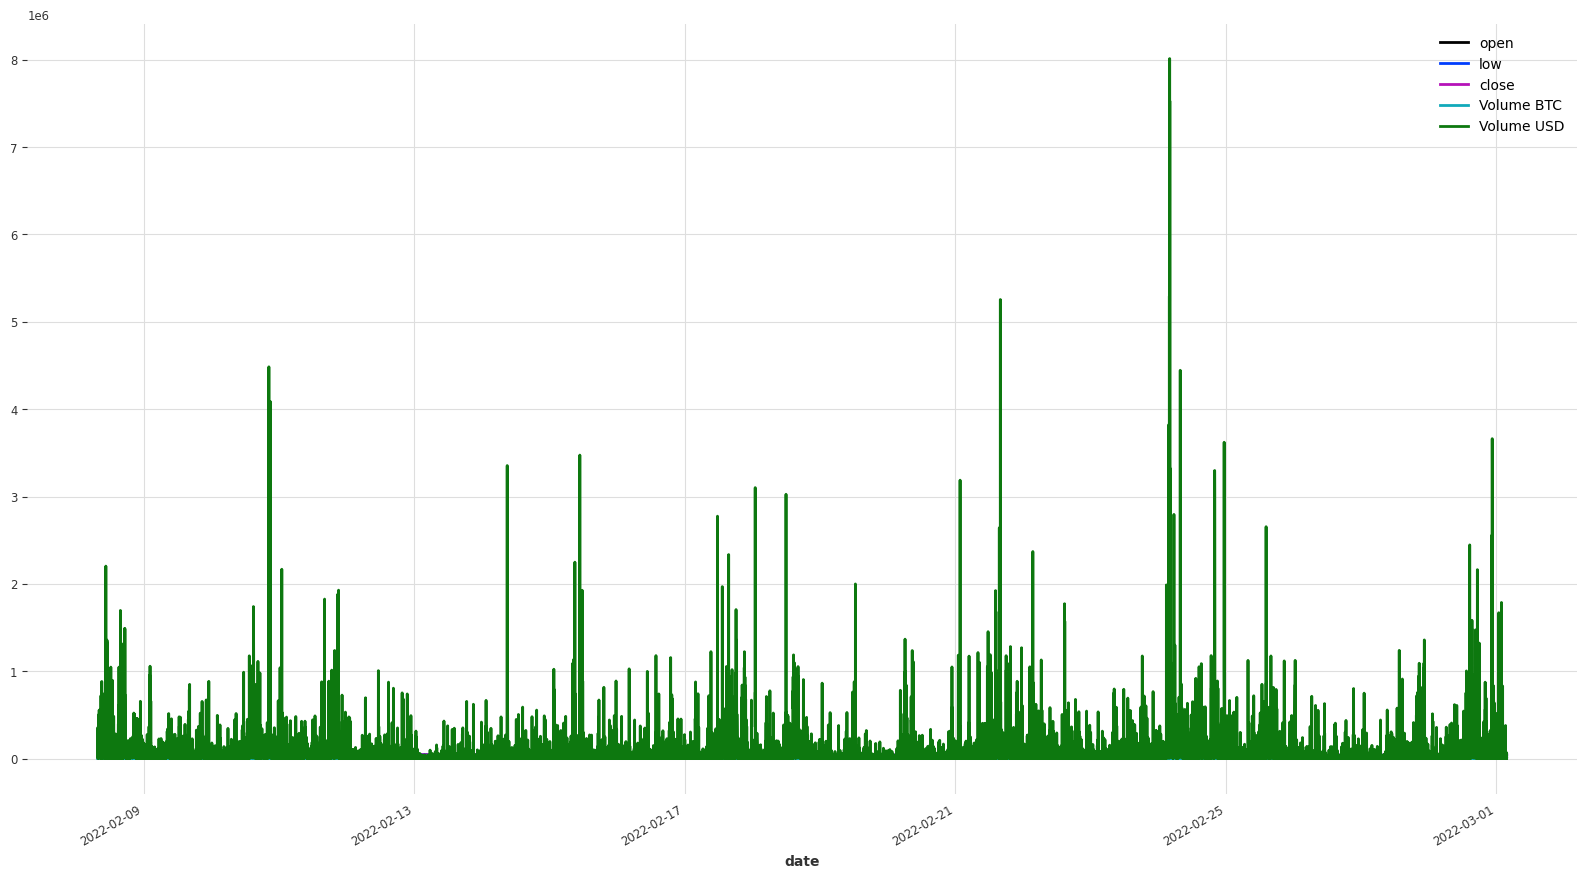

In [ ]:
past_cov.plot()

In [ ]:
scaler = Scaler()

target_scaled = scaler.fit_transform(target)

past_cov_scaled = scaler.fit_transform(past_cov)

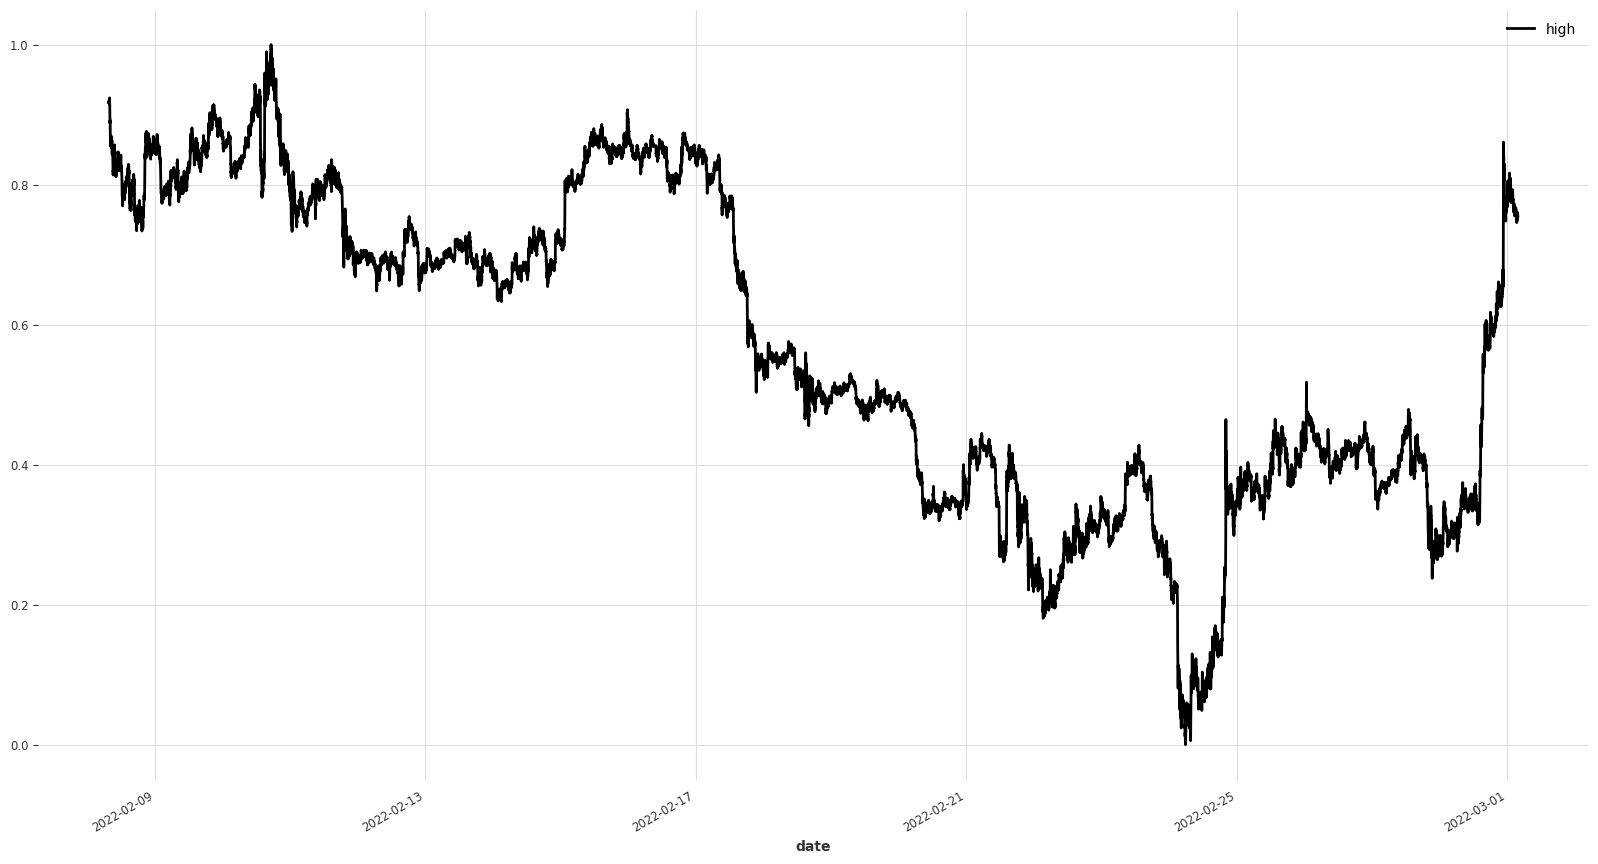

In [ ]:
target_scaled.plot()

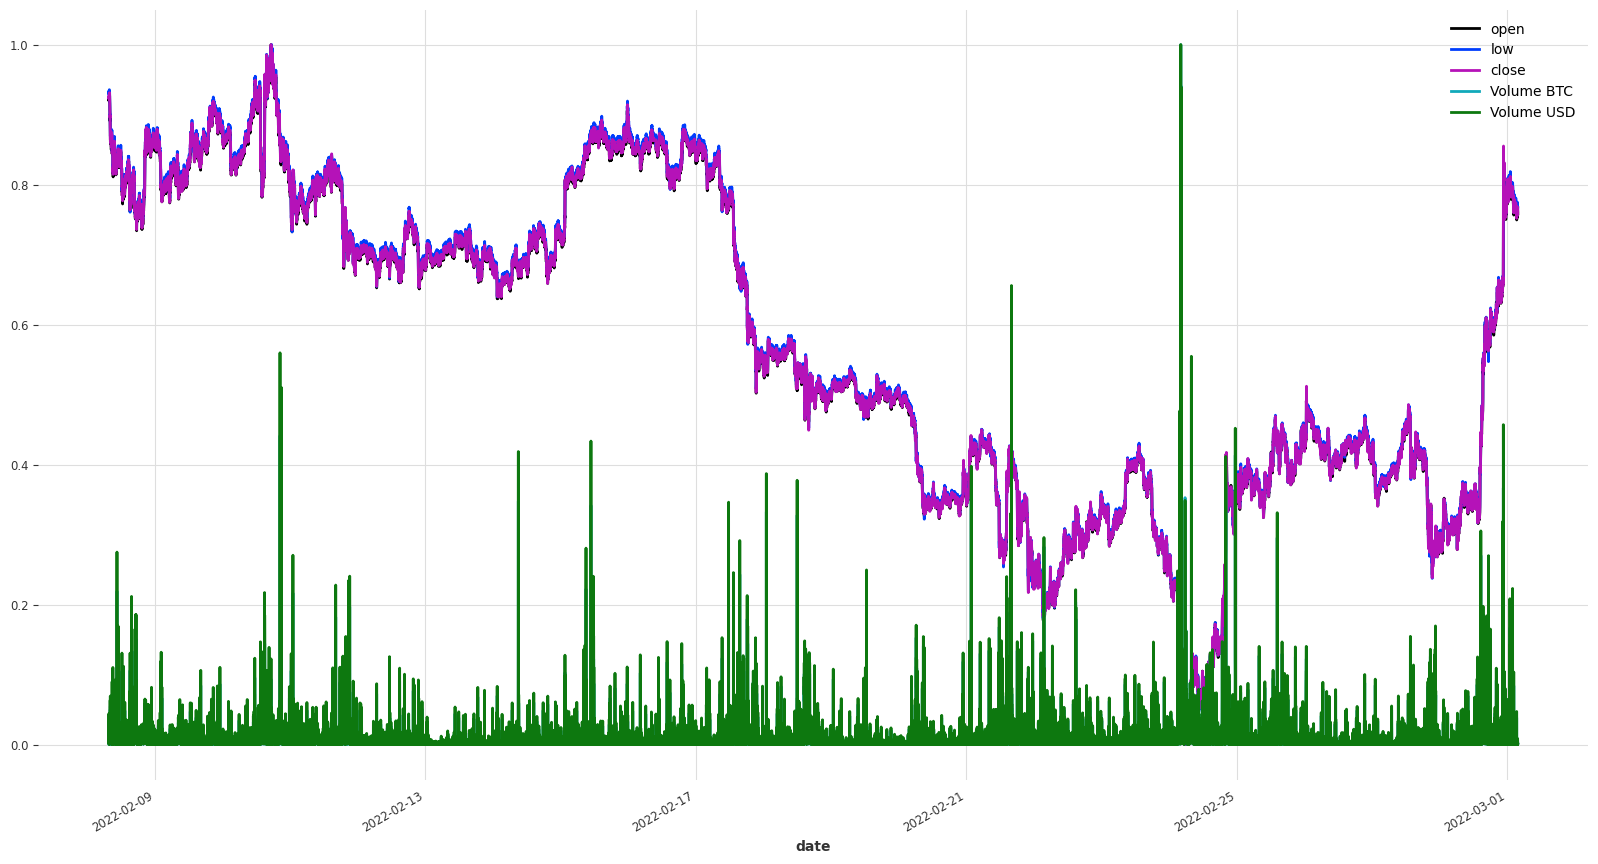

In [ ]:
past_cov_scaled.plot()

In [ ]:
#train-val split

train_size = int(len(small_df) * 0.8)

target_train, target_val = target_scaled[:train_size], target_scaled[train_size:]
past_cov_train, past_cov_val = past_cov_scaled[:train_size], past_cov_scaled[train_size:]

### N-BEATS Model

In [ ]:
nbeats =  NBEATSModel(
    input_chunk_length=24*7,  # Use a week of data as input
    output_chunk_length=24,  # Predict 24 hours ahead
    generic_architecture=True,  # Use the default architecture
    num_stacks=30,
    num_blocks=1,
    num_layers=4,
    layer_widths=256,
    dropout=0.1,
    batch_size = 128,
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    n_epochs = 10
)

In [ ]:
nbeats.fit(target_train, past_covariates = past_cov_train, val_series = target_val, val_past_covariates=past_cov_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 14.0 M
---------------------------------------------------
13.9 M    Trainable params
7.3 K     Non-trainable params
14.0 M    Total params
55.819    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


NBEATSModel(generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.1, activation=ReLU, input_chunk_length=168, output_chunk_length=24, batch_size=128, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': -1}, n_epochs=10)

In [ ]:
pred = nbeats.predict(n = len(target_val), series = target_train, past_covariates = past_cov_scaled, n_jobs = -1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

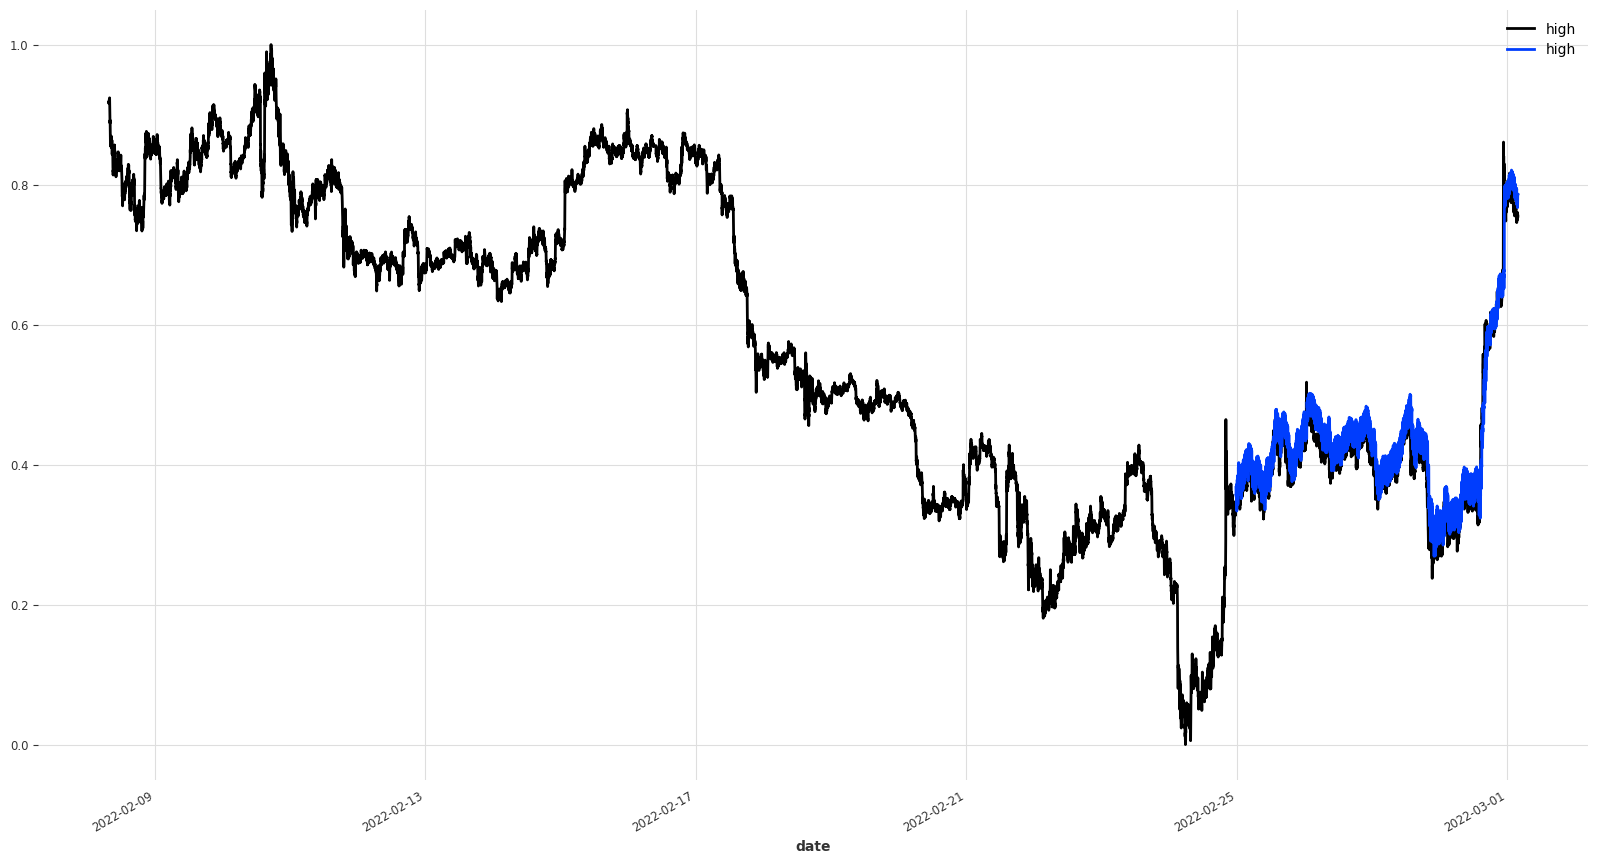

In [ ]:
target_scaled.plot()
pred.plot()

In [ ]:
target_val.pd_dataframe().reset_index()['high'].fillna(target_val.pd_dataframe().reset_index()['high'].mean())

0       0.341432
1       0.343378
2       0.344978
3       0.347188
4       0.347814
          ...   
5996    0.754031
5997    0.752902
5998    0.755029
5999    0.421231
6000    0.755028
Name: high, Length: 6001, dtype: float64

In [ ]:
pred.pd_dataframe().reset_index()['high'].dropna()

0       0.367245
1       0.358467
2       0.355992
3       0.357952
4       0.353489
          ...   
5996    0.780421
5997    0.786626
5998    0.785079
5999    0.785041
6000    0.785903
Name: high, Length: 6001, dtype: float64

In [ ]:
import numpy as np
from statsmodels.graphics.tsaplots import acf

def performance_metrics(forecast, actual):
    mape = np.mean((np.abs(actual - forecast)/actual)*100)
    me = np.mean(actual - forecast)
    mpe = np.mean(((forecast-actual)/actual)*100)
    mae = np.mean(np.abs(actual - forecast))
    rmse = np.sqrt(np.mean(forecast - actual)**2)
    corr = np.corrcoef(actual, forecast)[0,1]
    mins = np.amin(np.hstack([actual[:,None], forecast[:, None]]), axis = 1)
    maxs = np.amax(np.hstack([actual[:,None], forecast[:, None]]), axis = 1)
    minmax = 1 - np.mean(mins/maxs)
    acf1 = acf(actual - forecast)[1]
    return({'mape': mape, 'me': me, 'mae': mae, 'mpe':mpe, 'rmse': rmse, 'acf1': acf1, 
    'corr': corr, 'minmax': minmax})

In [ ]:
performance_metrics(target_val.pd_dataframe().reset_index()['high'].fillna(target_val.pd_dataframe().reset_index()['high'].mean()).to_numpy(),pred.pd_dataframe().reset_index()['high'].to_numpy())

{'mape': 6.561354433492384,
 'me': 0.0231401640033523,
 'mae': 0.027953040922811385,
 'mpe': -5.558144171761214,
 'rmse': 0.0231401640033523,
 'acf1': 0.8583202550441753,
 'corr': 0.9771269886887566,
 'minmax': 0.0651055355858563}

### RNN Model ~ DeepAR Model (by Amazon)

In [ ]:
from darts.models.forecasting.rnn_model import RNNModel
from darts.utils.likelihood_models import GaussianLikelihood

In [ ]:
rnn_model = RNNModel(input_chunk_length=24*7, # Use a week of data as input
                     model = "LSTM",
                     hidden_dim = 25,
                     n_rnn_layers = 2,
                     dropout = 0.1,
                     training_length= 24*14,
                     batch_size = 128,
                     n_epochs = 10,
                     pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
                     likelihood = GaussianLikelihood())

In [ ]:
rnn_model.fit(target_train, future_covariates = past_cov_train, val_series = target_val, val_future_covariates=past_cov_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 8.5 K 
4 | V             | Linear           | 52    
---------------------------------------------------
8.6 K     Trainable params
0         Non-trainable params
8.6 K     Total params
0.034     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


RNNModel(model=LSTM, hidden_dim=25, n_rnn_layers=2, dropout=0.1, training_length=336, input_chunk_length=168, batch_size=128, n_epochs=10, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': -1}, likelihood=<darts.utils.likelihood_models.GaussianLikelihood object at 0x7f4a580d0610>)

In [ ]:
pred_rnn_model = rnn_model.predict(n = len(target_val), series = target_train, future_covariates = TimeSeries.from_dataframe(past_cov_scaled.pd_dataframe().fillna(past_cov_scaled.pd_dataframe().mean())), n_jobs = -1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


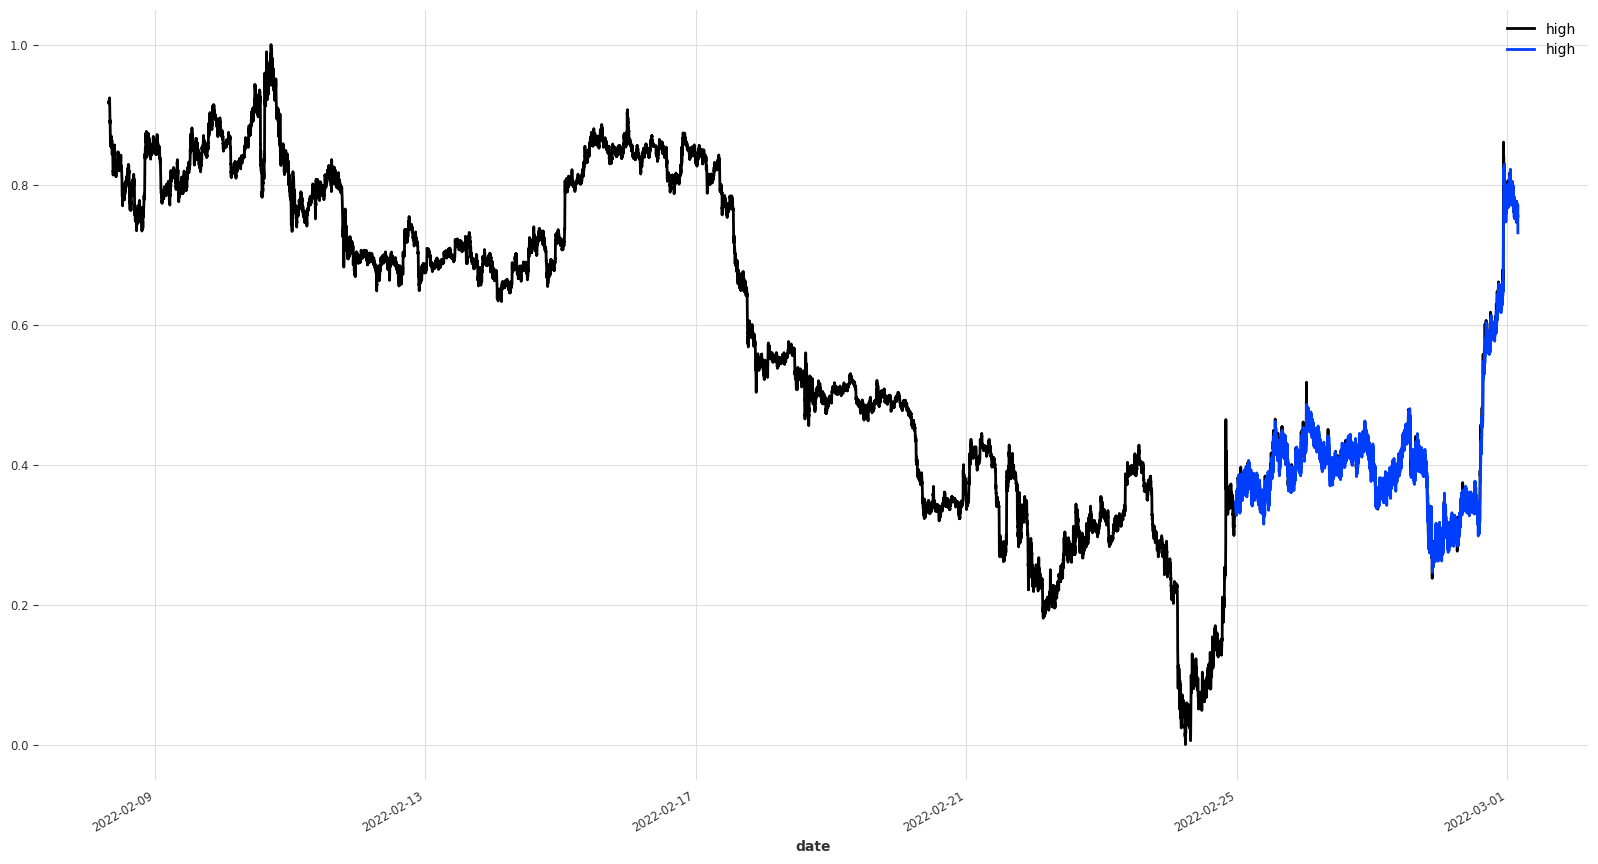

In [ ]:
target_scaled.plot()
pred_rnn_model.plot()

In [ ]:
performance_metrics(target_val.pd_dataframe().reset_index()['high'].fillna(target_val.pd_dataframe().reset_index()['high'].mean()).to_numpy(),pred_rnn_model.pd_dataframe().reset_index()['high'].to_numpy())

{'mape': 1.833932342891188,
 'me': -0.0019049147767537186,
 'mae': 0.007430284606653814,
 'mpe': 0.47818540320885267,
 'rmse': 0.0019049147767537186,
 'acf1': 0.3493684113360491,
 'corr': 0.9953270802880843,
 'minmax': 0.017960128496470107}

### Block RNN Model

In [ ]:
from darts.models.forecasting.block_rnn_model import BlockRNNModel


In [ ]:
block_rnn = BlockRNNModel(input_chunk_length=24*7, # Use a week of data as input
                          output_chunk_length=24,
                     model = "RNN",
                     hidden_dim = 25,
                     n_rnn_layers = 2,
                     dropout = 0.1,
                     batch_size = 128,
                     pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
                     n_epochs = 10)

In [ ]:
block_rnn.fit(target_train, past_covariates = past_cov_train, val_series = target_val, val_past_covariates=past_cov_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.1 K 
4 | fc            | Sequential       | 624   
---------------------------------------------------
2.7 K     Trainable params
0         Non-trainable params
2.7 K     Total params
0.011     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


BlockRNNModel(model=RNN, hidden_dim=25, n_rnn_layers=2, hidden_fc_sizes=None, dropout=0.1, input_chunk_length=168, output_chunk_length=24, batch_size=128, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': -1}, n_epochs=10)

In [ ]:
pred_block_rnn_model = block_rnn.predict(n = len(target_val), series = target_train, past_covariates = TimeSeries.from_dataframe(past_cov_scaled.pd_dataframe().fillna(past_cov_scaled.pd_dataframe().mean())), n_jobs = -1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

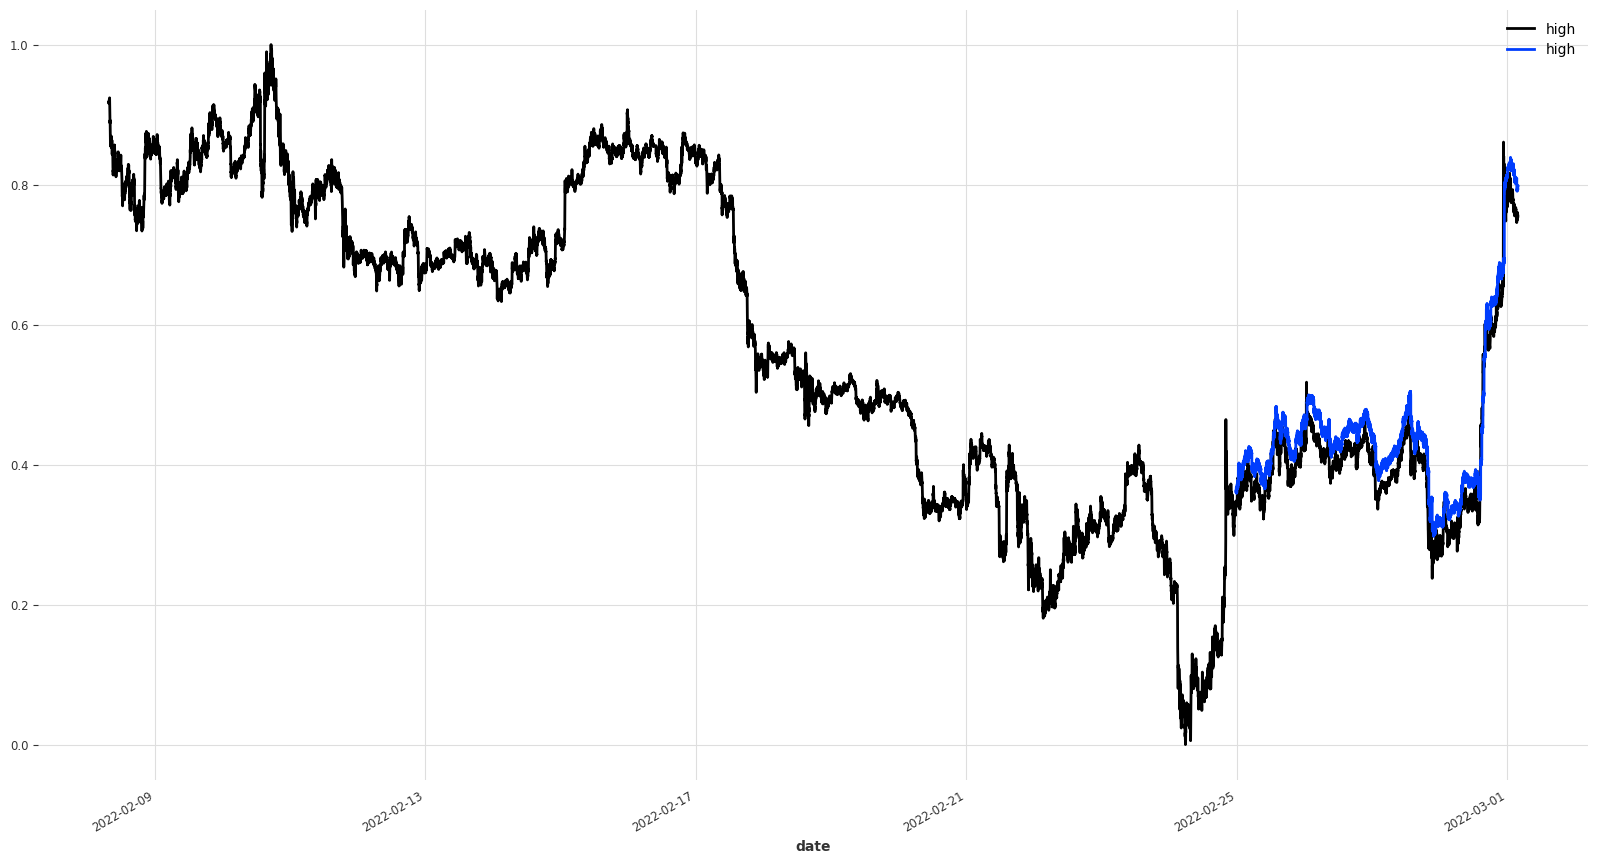

In [ ]:
target_scaled.plot()
pred_block_rnn_model.plot()

In [ ]:
performance_metrics(target_val.pd_dataframe().reset_index()['high'].fillna(target_val.pd_dataframe().reset_index()['high'].mean()).to_numpy(),pred_block_rnn_model.pd_dataframe().reset_index()['high'].to_numpy())

{'mape': 7.399275643262376,
 'me': 0.0299432011642611,
 'mae': 0.03235211210849571,
 'mpe': -6.930162766957047,
 'rmse': 0.0299432011642611,
 'acf1': 0.8886027481218837,
 'corr': 0.984790885363563,
 'minmax': 0.0737579358263768}

### Temporal Fusion Transformer (TFT) Model

In [ ]:
from darts.models.forecasting.tft_model import TFTModel

In [ ]:
from darts.utils.likelihood_models import QuantileRegression

# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 24*7
forecast_horizon = 24
tft_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=64,
    lstm_layers=1,
    num_attention_heads=4,
    dropout=0.1,
    batch_size=128,
    n_epochs=10,
    add_relative_index=True,
    add_encoders={
    'cyclic': {'future': ['month']},
    'datetime_attribute': {'future': ['hour', 'dayofweek']},
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'past': [lambda idx: (idx.year - 1950) / 50]},
    'transformer': Scaler()
},
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=42,
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1}

)

In [ ]:
tft_model.fit(target_train, past_covariates = past_cov_train, val_series = target_val, val_past_covariates=past_cov_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


TFTModel(hidden_size=64, lstm_layers=1, num_attention_heads=4, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.1, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=True, loss_fn=None, likelihood=<darts.utils.likelihood_models.QuantileRegression object at 0x7f4a5a59a7a0>, norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=168, output_chunk_length=24, batch_size=128, n_epochs=10, add_encoders={'cyclic': {'future': ['month']}, 'datetime_attribute': {'future': ['hour', 'dayofweek']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'custom': {'past': [<function <lambda> at 0x7f4a44cb2200>]}, 'transformer': Scaler}, random_state=42, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': -1})

In [ ]:
pred_tft_model = tft_model.predict(n = len(target_val), series = target_train, past_covariates = TimeSeries.from_dataframe(past_cov_scaled.pd_dataframe().fillna(past_cov_scaled.pd_dataframe().mean())), n_jobs = -1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

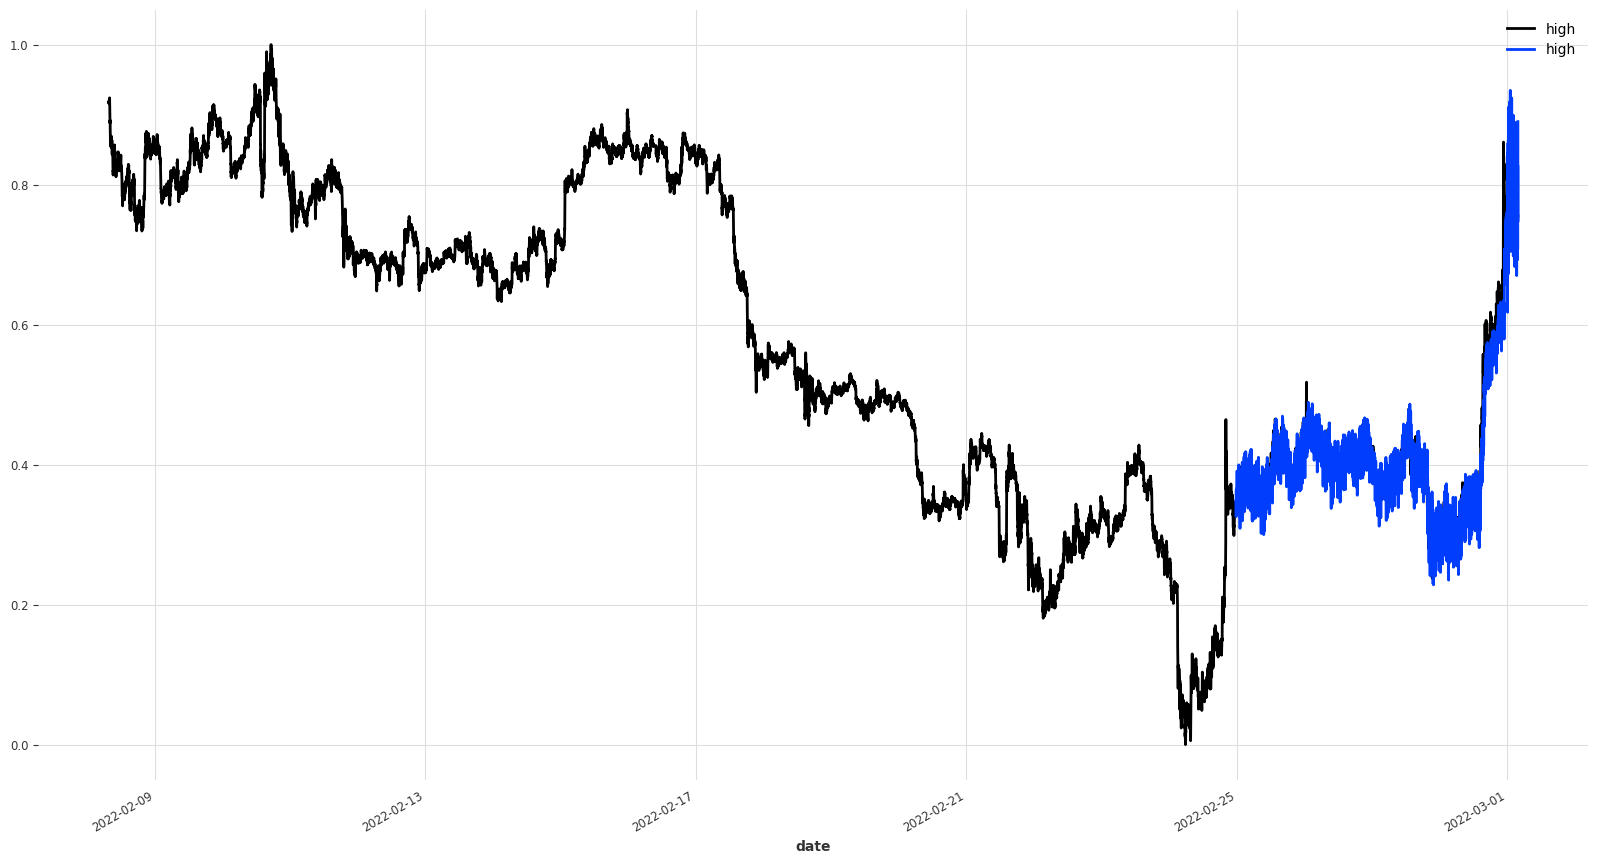

In [ ]:
target_scaled.plot()
pred_tft_model.plot()

In [ ]:
performance_metrics(target_val.pd_dataframe().reset_index()['high'].fillna(target_val.pd_dataframe().reset_index()['high'].mean()).to_numpy(),pred_tft_model.pd_dataframe().reset_index()['high'].to_numpy())

{'mape': 4.769538170281495,
 'me': -0.008004684109744526,
 'mae': 0.0202138644288071,
 'mpe': 1.9945547971903241,
 'rmse': 0.008004684109744526,
 'acf1': 0.5894403082209504,
 'corr': 0.9646663100576003,
 'minmax': 0.04487475850845346}

### Temporal Convolutional Network (TCN) Model

In [ ]:
from darts.models.forecasting.tcn_model import TCNModel

In [ ]:
tcn_model = TCNModel(input_chunk_length = 24*7, 
                     output_chunk_length = 24, 
                     kernel_size=3, 
                     num_filters=3, 
                     num_layers=5, 
                     dilation_base=2, 
                     weight_norm=False, 
                     dropout=0.2,
                     batch_size = 128,
                     pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
                     n_epochs = 10)

In [ ]:
tcn_model.fit(target_train, past_covariates = past_cov_train, val_series = target_val, val_past_covariates=past_cov_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type              | Params
----------------------------------------------------
0 | criterion     | MSELoss           | 0     
1 | train_metrics | MetricCollection  | 0     
2 | val_metrics   | MetricCollection  | 0     
3 | dropout       | MonteCarloDropout | 0     
4 | res_blocks    | ModuleList        | 332   
----------------------------------------------------
332       Trainable params
0         Non-trainable params
332       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


TCNModel(kernel_size=3, num_filters=3, num_layers=5, dilation_base=2, weight_norm=False, dropout=0.2, input_chunk_length=168, output_chunk_length=24, batch_size=128, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': -1}, n_epochs=10)

In [ ]:
pred_tcn_model = tcn_model.predict(n = len(target_val), series = target_train, past_covariates = TimeSeries.from_dataframe(past_cov_scaled.pd_dataframe().fillna(past_cov_scaled.pd_dataframe().mean())), n_jobs = -1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

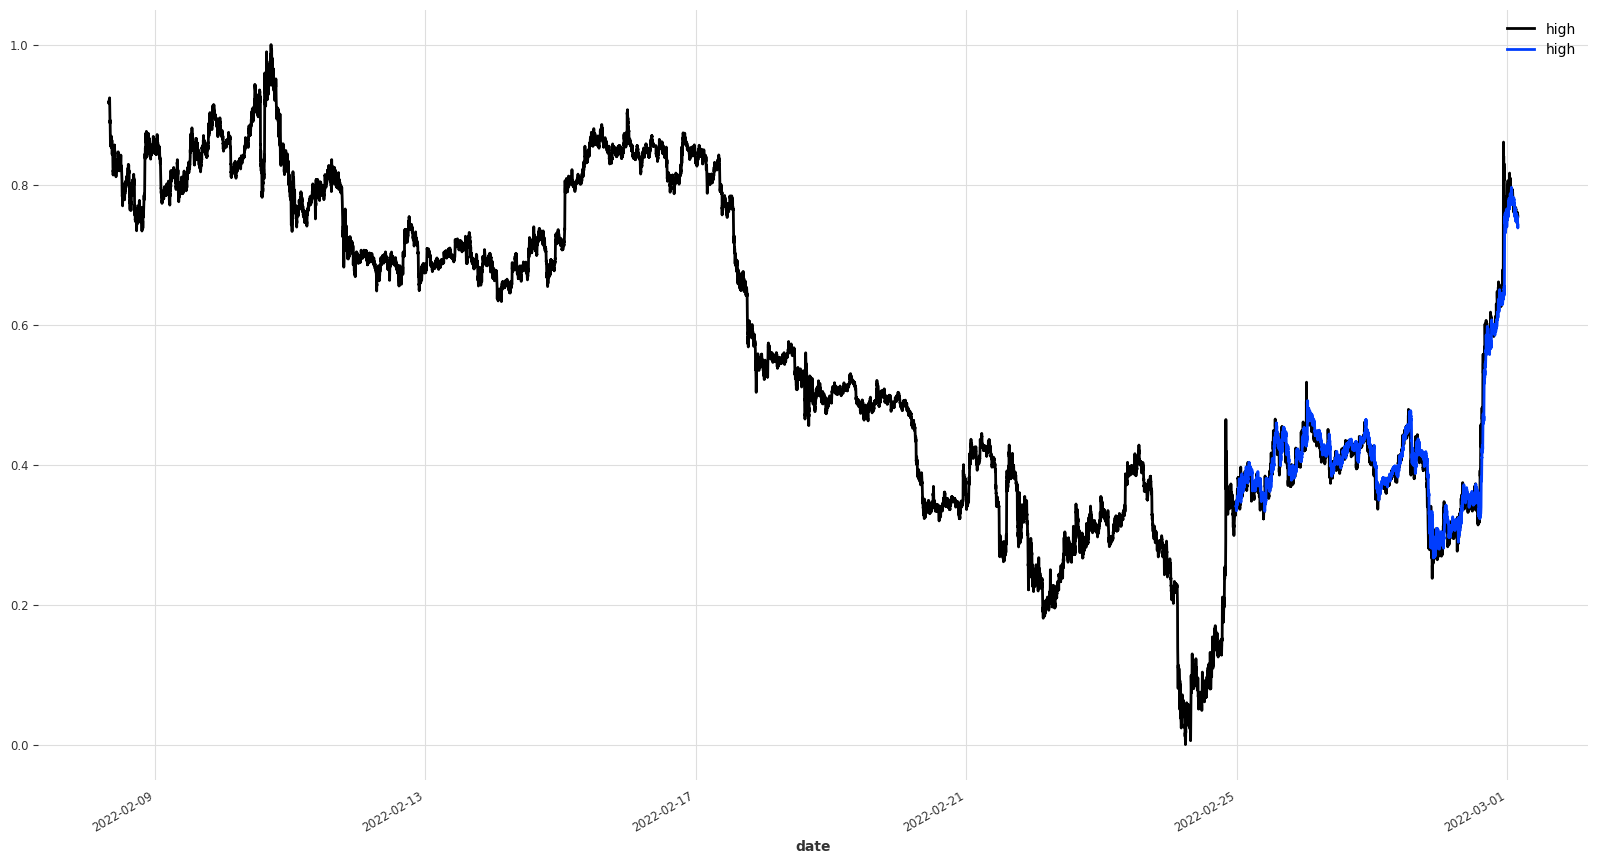

In [ ]:
target_scaled.plot()
pred_tcn_model.plot()

In [ ]:
performance_metrics(target_val.pd_dataframe().reset_index()['high'].fillna(target_val.pd_dataframe().reset_index()['high'].mean()).to_numpy(),pred_tcn_model.pd_dataframe().reset_index()['high'].to_numpy())

{'mape': 3.462521711178727,
 'me': 0.002401946950581984,
 'mae': 0.014289923020494455,
 'mpe': -0.7893363110872196,
 'rmse': 0.002401946950581984,
 'acf1': 0.9421329951632457,
 'corr': 0.980169956709784,
 'minmax': 0.033491145854891324}

### FbProphet

In [ ]:
from prophet import Prophet

In [ ]:
small_df

,open,high,low,close,Volume BTC,Volume USD
date,,,,,,
2022-03-01 03:43:00,43046.58,43046.58,43046.58,43046.58,0.000000,0.000000
2022-03-01 03:41:00,43018.23,43046.59,43018.23,43046.58,0.142977,6154.673021
2022-03-01 03:40:00,43022.24,43022.24,43016.03,43016.03,0.009230,397.037957
2022-03-01 03:39:00,43035.16,43035.16,42999.44,42999.44,0.820950,35300.390268
2022-03-01 03:38:00,43077.82,43077.82,43049.46,43049.46,0.022210,956.143143
...,...,...,...,...,...,...
2022-02-08 07:47:00,44861.69,44884.22,44861.69,44884.22,0.031300,1404.876086
2022-02-08 07:46:00,44890.16,44890.16,44844.50,44861.69,0.910237,40834.790757
2022-02-08 07:45:00,44917.76,44917.76,44885.10,44890.16,7.895788,354443.169588


In [ ]:
df_prophet = small_df.reset_index().rename(columns = {'high':'y', "date": "ds"})

In [ ]:
df_prophet

,ds,open,y,low,close,Volume BTC,Volume USD
0,2022-03-01 03:43:00,43046.58,43046.58,43046.58,43046.58,0.000000,0.000000
1,2022-03-01 03:41:00,43018.23,43046.59,43018.23,43046.58,0.142977,6154.673021
2,2022-03-01 03:40:00,43022.24,43022.24,43016.03,43016.03,0.009230,397.037957
3,2022-03-01 03:39:00,43035.16,43035.16,42999.44,42999.44,0.820950,35300.390268
4,2022-03-01 03:38:00,43077.82,43077.82,43049.46,43049.46,0.022210,956.143143
...,...,...,...,...,...,...,...
29995,2022-02-08 07:47:00,44861.69,44884.22,44861.69,44884.22,0.031300,1404.876086
29996,2022-02-08 07:46:00,44890.16,44890.16,44844.50,44861.69,0.910237,40834.790757
29997,2022-02-08 07:45:00,44917.76,44917.76,44885.10,44890.16,7.895788,354443.169588
29998,2022-02-08 07:44:00,44911.20,44912.32,44906.50,44912.32,0.365327,16407.675943


In [ ]:
# Split data into train and test sets
train_size = int(len(df_prophet) * 0.8)
train_df_prophet = df_prophet[:train_size]
test_df_prophet = df_prophet[train_size:]

In [ ]:
# Create Prophet model and fit on training data
prophet_model = Prophet()

In [ ]:
# Adding regressors
prophet_model.add_regressor("open")
prophet_model.add_regressor("low")
prophet_model.add_regressor("close")
prophet_model.add_regressor("Volume BTC")
prophet_model.add_regressor("Volume USD")

In [ ]:
prophet_model.fit(train_df_prophet)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmqk212g4/l5ceseq_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmqk212g4/_cki88xd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3204', 'data', 'file=/tmp/tmpmqk212g4/l5ceseq_.json', 'init=/tmp/tmpmqk212g4/_cki88xd.json', 'output', 'file=/tmp/tmpmqk212g4/prophet_modelbbzvlp3p/prophet_model-20230503203451.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:34:51 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:35:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
forecast_df = prophet_model.predict(test_df_prophet)

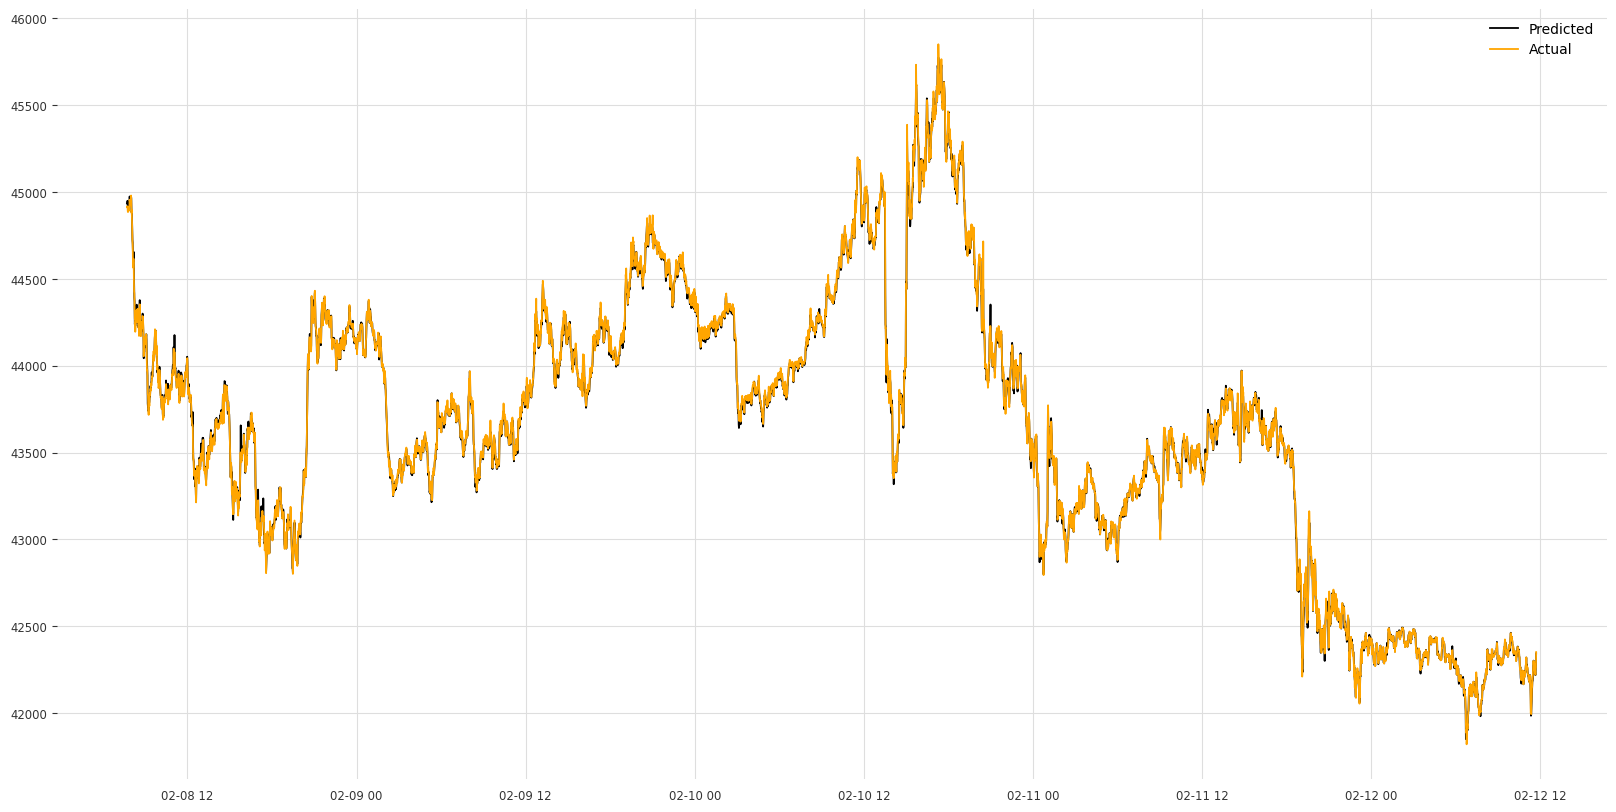

In [ ]:
# Plot actual and predicted Bitcoin prices
plt.plot(forecast_df['ds'], forecast_df['yhat'], label = "Predicted" )
plt.plot(test_df_prophet['ds'], test_df_prophet['y'], color = 'orange', label = "Actual")
plt.legend()
plt.show()

In [ ]:
performance_metrics(test_df_prophet['y'].to_numpy(), forecast_df['yhat'].to_numpy())

{'mape': 2.0012999119556527,
 'me': -4.914560549142848,
 'mae': 871.5808807537359,
 'mpe': 0.03958063656651514,
 'rmse': 4.914560549142848,
 'acf1': 0.9974280884466603,
 'corr': 0.1129873467951355,
 'minmax': 0.01972734729758241}

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install darts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.9/693.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 20.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 55.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.0/100.0 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 46.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.4/372

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20, 10)

In [ ]:
# Load Bitcoin price data
bitcoin_df = pd.read_csv(r"/content/gdrive/MyDrive/BTC-2021min.csv", parse_dates = ['date'], usecols = ["date", "open", "high", "low", "close", "Volume BTC", "Volume USD"])

In [ ]:
small_df = bitcoin_df.iloc[:30000, :]

In [ ]:
from darts import TimeSeries
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score

In [ ]:
small_df.set_index("date", inplace = True)

In [ ]:
target = TimeSeries.from_series(small_df['high'],fill_missing_dates = True, freq = None)

In [ ]:
cov = TimeSeries.from_dataframe(small_df.drop('high', axis = 1),fill_missing_dates = True, freq = None)

In [ ]:
scaler = Scaler()

target_scaled = scaler.fit_transform(target)

cov_scaled = scaler.fit_transform(cov)

In [ ]:
#train-val split

train_size = int(len(small_df) * 0.8)

target_train, target_val = target_scaled[:train_size], target_scaled[train_size:]
cov_train, cov_val = cov_scaled[:train_size], cov_scaled[train_size:]

### DLinear Model

In [ ]:
from darts.models.forecasting.dlinear import DLinearModel

In [ ]:
dl_model =  DLinearModel(
    input_chunk_length=24*7,  # Use a week of data as input
    output_chunk_length=24,  # Predict 24 hours ahead
    kernel_size = 25,
    batch_size = 128,
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    n_epochs = 10
)

In [ ]:
dl_model.fit(target_train, past_covariates = cov_train, val_series = target_val, val_past_covariates=cov_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 24.2 K
5 | linear_trend    | Linear           | 24.2 K
-----------------------------------------------------
48.4 K    Trainable params
0         Non-trainable params
48.4 K    Total params
0.194     Total esti

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


DLinearModel(shared_weights=False, kernel_size=25, const_init=True, use_static_covariates=True, input_chunk_length=168, output_chunk_length=24, batch_size=128, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': -1}, n_epochs=10)

In [ ]:
pred_dl_model = dl_model.predict(n = len(target_val), series = target_train, past_covariates = cov_scaled, n_jobs = -1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

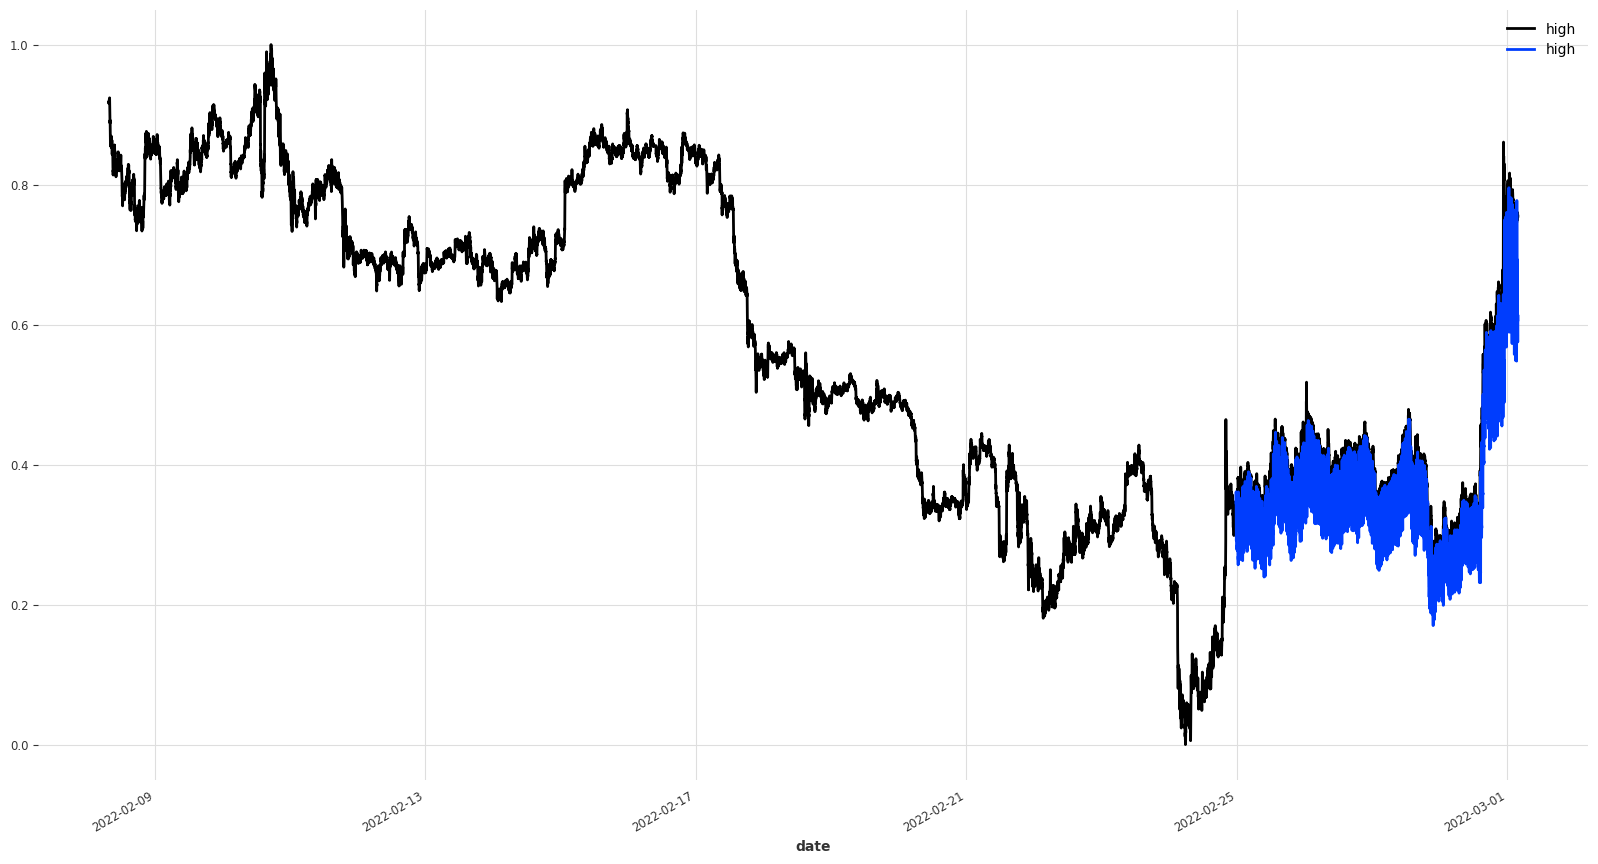

In [ ]:
target_scaled.plot()
pred_dl_model.plot()

In [ ]:
import numpy as np
from statsmodels.graphics.tsaplots import acf

def performance_metrics(forecast, actual):
    mape = np.mean((np.abs(actual - forecast)/actual)*100)
    me = np.mean(actual - forecast)
    mpe = np.mean(((forecast-actual)/actual)*100)
    mae = np.mean(np.abs(actual - forecast))
    rmse = np.sqrt(np.mean(forecast - actual)**2)
    corr = np.corrcoef(actual, forecast)[0,1]
    mins = np.amin(np.hstack([actual[:,None], forecast[:, None]]), axis = 1)
    maxs = np.amax(np.hstack([actual[:,None], forecast[:, None]]), axis = 1)
    minmax = 1 - np.mean(mins/maxs)
    acf1 = acf(actual - forecast)[1]
    return({'mape': mape, 'me': me, 'mae': mae, 'mpe':mpe, 'rmse': rmse, 'acf1': acf1, 
    'corr': corr, 'minmax': minmax})

In [ ]:
performance_metrics(target_val.pd_dataframe().reset_index()['high'].fillna(target_val.pd_dataframe().reset_index()['high'].mean()).to_numpy(),pred_dl_model.pd_dataframe().reset_index()['high'].to_numpy())

{'mape': 23.51680588834156,
 'me': -0.07762983541886481,
 'mae': 0.0777679227762988,
 'mpe': 23.487738437214553,
 'rmse': 0.07762983541886481,
 'acf1': 0.791856198227712,
 'corr': 0.9438200198294838,
 'minmax': 0.18450255628313617}

### NLinear Model

In [ ]:
from darts.models.forecasting.nlinear import NLinearModel

In [ ]:
nl_model =  NLinearModel(
    input_chunk_length=24*7,  # Use a week of data as input
    output_chunk_length=24,  # Predict 24 hours ahead
    batch_size = 128,
    pl_trainer_kwargs = {"accelerator": "gpu", "devices": -1},
    n_epochs = 10,
)

In [ ]:
nl_model.fit(target_train, past_covariates = cov_train, val_series = target_val, val_past_covariates=cov_val)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | layer         | Linear           | 24.2 K
---------------------------------------------------
24.2 K    Trainable params
0         Non-trainable params
24.2 K    Total params
0.097     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


NLinearModel(shared_weights=False, const_init=True, normalize=False, use_static_covariates=True, input_chunk_length=168, output_chunk_length=24, batch_size=128, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': -1}, n_epochs=10)

In [ ]:
pred_nl_model = nl_model.predict(n = len(target_val), series = target_train, past_covariates = cov_scaled, n_jobs = -1)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

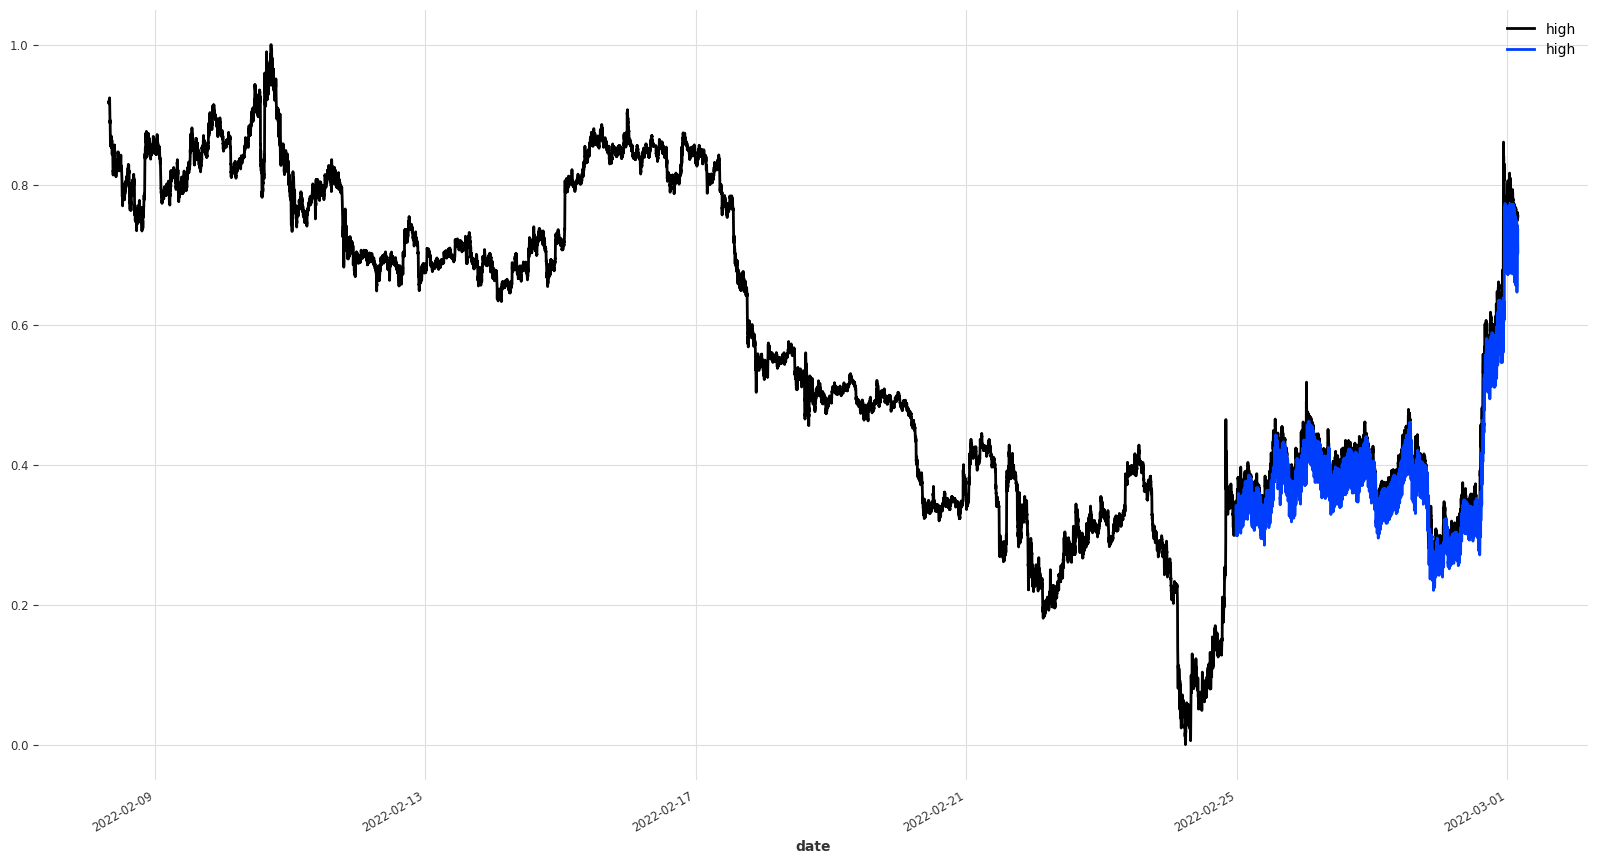

In [ ]:
target_scaled.plot()
pred_nl_model.plot()

In [ ]:
performance_metrics(target_val.pd_dataframe().reset_index()['high'].fillna(target_val.pd_dataframe().reset_index()['high'].mean()).to_numpy(),pred_nl_model.pd_dataframe().reset_index()['high'].to_numpy())

{'mape': 7.617473814880676,
 'me': -0.027434606941799226,
 'mae': 0.029251482414379314,
 'mpe': 7.128121617485892,
 'rmse': 0.027434606941799226,
 'acf1': 0.8683069836729225,
 'corr': 0.9738072459351849,
 'minmax': 0.06852734559405094}